### v3 
Add "Some Notes" and then need to run remport with All Disaggreated just to track  Specs positioning.

In [1]:
import datetime as dt
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay #use last BD to bypass feed issues on hols and early mrng
#import datetime as dt#  --->NameError: name 'datetime' is not defined
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  #need if want to display all months 

import plotly.express as px
import DownloadData_v4

import os
import importlib.machinery
import sys


pd.set_option('display.max_rows', 200) #https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.options.display.max_rows 
#pd.set_option('display.max_columns', 60) #https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.options.display.max_columns = None


from IPython.core.interactiveshell import InteractiveShell # This line imports the InteractiveShell class from the IPython.core.interactiveshell module.
InteractiveShell.ast_node_interactivity = "all" #This line sets the ast_node_interactivity attribute of the InteractiveShell instance to "all." The ast_node_interactivity attribute controls how IPython deals with multi-line output, specifically when multiple statements are executed in a cell.

cwd = os.getcwd()

#sys.path #returns all working directories 
print(cwd)
#sys.path

#def download_format_data(secs, start , end, asset_class):
    
'''the COT report comes out on a Friday.....but for data of prev TUESDAY. So if blpapi calls both
underlyings' weekly (which is marked for friday) and COT , we get mismatches.
so we are foced to call the undelrying on a daily and then merge.
secs dictionary of securities, 
start & end datetime objects
asset_class = 'Crncy', 'Comdty' '''


C:\Users\CP85VC\OneDrive - ING\BWAM\AndrewIsAwesome


"the COT report comes out on a Friday.....but for data of prev TUESDAY. So if blpapi calls both\nunderlyings' weekly (which is marked for friday) and COT , we get mismatches.\nso we are foced to call the undelrying on a daily and then merge.\nsecs dictionary of securities, \nstart & end datetime objects\nasset_class = 'Crncy', 'Comdty' "

#### Some notes
https://www.cftc.gov/MarketReports/CommitmentsofTraders/DisaggregatedExplanatoryNotes/index.htm

CFTC began publishing a Disaggregated Commitments of Traders (Disaggregated COT) report on September 4, 2009. The first iteration of the report covered 22 major physical commodity markets; on December 4, 2009, the remaining physical commodity markets were included.1

The Disaggregated COT report increases transparency from the legacy COT reports by separating traders into the following four categories of traders: Producer/Merchant/Processor/User; Swap Dealers; Managed Money; and Other Reportables. The legacy COT report separates reportable traders only into “commercial” and “non-commercial” categories.

***
This initiative for providing market transparency arises from the recommendation to disaggregate the existing “commercial” category in the Commission’s September 2008 Staff Report on Commodity Swap Dealers & Index Traders.3 Specifically, that report recommended:

Remove Swap Dealer from Commercial Category and Create New Swap Dealer Classification for Reporting Purposes: In order to provide for increased transparency of the exchange traded futures and options markets, the Commission has instructed the staff to develop a proposal to enhance and improve the CFTC‘s weekly Commitments of Traders Report by including more delineated trader classification categories beyond commercial and non-commercial, which may include at a minimum the addition of a separate category identifying the trading of swap dealers.

***

On {COT GO} in BBG you have as standard All Legacy (top left), then can toggle to get All Disaggregated. There is decent amount of diffenrce in magnitude though change semes to match somewhat .

In [99]:
'''
can get tickers from COT <GO>
Added ES on 2023.07.24 using 'new format', so instead of commercial vs cnoncommercial,
clicked to disaggregated and created one for AssetManagers and Levered funds

'''
secs = {'AUDUSD' : ['IMM6ANCL Index', 'IMM6ANCS Index'],#ctr size: AUD100k,ctr value: price$/aud * 100k Aud = 80kish
        'EURUSD' : ['IMMBENCL Index', 'IMMBENCS Index'],
        'GBPUSD' : ['IMM5PNCL Index', 'IMM5PNCS Index'],
        'NZDUSD' : ['IMM6ZNCL Index', 'IMM6ZNCS Index'],
        'USDCAD' : [ 'IMM3CNCL Index', 'IMM3CNCS Index'],
       'USDJPY' : ['IMM5JNCL Index', 'IMM5JNCS Index']
       } #ctr size: JPY12.5mio, ctr value: 88$/100yen *ctr size..$110kish..also upside down btw so higher means weaker usd, lower means stronger.

rates = {'TU1' : ['CBT42NCL Index', 'CBT42NCS Index'], #ZN  = TU
        'FV1':['CBT55NCL Index', 'CBT55NCS Index'], #FV = ZF
        'TY1': ['CBT4TNCL Index', 'CBT4TNCS Index'], #TY = ZT
        'US1': [' CBT3TNCL Index', 'CBT3TNCS Index']
        } #US = ZB

stonks_assetManager = {'ES1': ['TFF1NAIL Index', 'TFF1NAIS Index']} #asset manager
                      
stonks_levered =  {'ES1': ['TFF1NLFL Index', 'TFF1NLFS Index']} # Levered (others are assetmanager and dealer)

start_ =  dt.datetime(2016, 1 , 9)
end_ = dt.datetime.today() #dt.datetime(2021, 10,12)

frequency = 'WEEKLY'
asset_class = 'CURNCY'

def download_format_data(secs, start, end, asset_class, zscore_window):
    
    #create list of securiteis names to feed in dictionary below  
    titles = []
    for sec in secs:
        titles.append(sec)

    datasets = {} #contians weekly values
    underlyings = {} #containts daily values
    merged = {}

    i  = 0 
    for sec in secs.values():
        #downlowad COT data, WEEKLY as released every FRIDAY (except  holidays) for preceding TUESDAY
        datasets[titles[i]] = DownloadData_v4.DownloadData(pair = sec, \
                                                     fields = ['PX_LAST'], \
                                                     startDate = start_, \
                                                     endDate = end_, \
                                                     period = 'WEEKLY', \
                                                    source = 'blp').get_data_blp_historical(0)
        #donwload underlyings , DAILY..to match above TUESDAY

        underlyings[titles[i]] = DownloadData_v4.DownloadData(pair = titles[i]+str(' '+asset_class) , \
                                                     fields = ['PX_LAST'], \
                                                     startDate = start_, \
                                                     endDate = end_, \
                                                     period = 'DAILY', \
                                                    source = 'blp').get_data_blp_historical(0)

        
        ##merge COT weekly tuesdays with EOD dailys
        merged[titles[i]]   = pd.merge(datasets[titles[i]], underlyings[titles[i]], how = 'inner' , left_index = True, \
                                       right_index = True).set_axis([sec[0], sec[1], titles[i]], axis = 'columns')

        ##reorder columns:  
        ## merged[AUDUSD] = merged['AUDUSD']['AUDUSD', 'IMM6ANCL', 'IMM6ANCS']
        merged[titles[i]] = merged[titles[i]]   [[titles[i], sec[0], sec[1] ]]

        ##format:  add  net position : ie NonCommercialLongs = sec[0] - NonCommercialShorts = sec[1]
        merged[titles[i]]['net_spec'] =  merged[titles[i]][sec[0]] - merged[titles[i]][sec[1]] 
        
        ##add weekly change in net position
        merged[titles[i]]['weekly_change'] = merged[titles[i]]['net_spec'] - merged[titles[i]]['net_spec'].shift(1)
       
        ##then add z score
        r = merged[titles[i]]['net_spec'].rolling(window = zscore_window)
        m = r.mean().shift(1)
        s = r.std(ddof = 0).shift(1)
        z = (merged[titles[i]]['net_spec']-m)/s
        
        merged[titles[i]]['z_score'] = round(z,3)
        
        '''
        horrendous syntax below, create columns for position in bio: 
        merged[titles[i]]blabla -> merged['USDJPY'][str()'USDJPY')+'_in_bio']
        '''
        
        if 'USDJPY' in titles[i]:
            '''
            dollar amount of spec position for yen is 12.5mio yen per contr * net_spec /  spot
            (ie 113 yen per $)..so a positive amount is market long Yen/ Short USD and viceversa       
            ''' 
            #print('im in USDJPY')
            multiplier = 12.5e6 #contract size 12.mio jpy
            
        elif  titles[i] == 'AUDUSD' or \
                titles[i] == 'EURUSD' or \
                titles[i] == 'GBPUSD' or \
                titles[i] == 'NZDUSD' or \
                titles[i] == 'USDCAD':
        
            '''
            dollar amount of spec position is 100k eur  per contract spot
            (ie 1.13usd per eur) * net_spec ..so a positive amount is client long EUR  
           '''
            multiplier = 100e3
            
        elif 'ES' in titles[i]:
            '''
            dollar amount of spec position is 50 * index * *net positions
            ''' 
            multiplier = 50
            
            print('im in ES and mult is '+str(multiplier))
        
        #careful with the 'US' as may override elif above with 'USD'
        
        elif 'TU' in titles[i]:
            # dollar amount of spec position is 2000  * *net positions
            multiplier = 2000
            
        elif  'FV' in titles[i] or 'TY' in titles[i] or 'US' in titles[i]:
        # dollar amount of spec position is 1000  * *net positions
            #print('im in rates')
            multiplier = 1000
            
        if 'USDJPY' in titles[i]: 
        
            merged[titles[i]][str(titles[i])+str('_bio')] = round(multiplier * merged[titles[i]]['net_spec'] / \
                                                                     merged[titles[i]][titles[i]] ) /1e9                                                                                                                                                                                 

            merged[titles[i]][str(titles[i])+str('_week_chng_bio')] =merged[titles[i]][str(titles[i])+str('_bio')]\
            - merged[titles[i]][str(titles[i])+str('_bio')].shift(1)
        
        else:
        
            merged[titles[i]][str(titles[i])+str('_bio')] = round( merged[titles[i]][titles[i]] * \
                                                                  merged[titles[i]]['net_spec']*multiplier)/1e9
            
            merged[titles[i]][str(titles[i])+str('_week_chng_bio')] =merged[titles[i]][str(titles[i])+str('_bio')]\
            - merged[titles[i]][str(titles[i])+str('_bio')].shift(1)
        
        #append descirptive stats..aobut 8 rows to chop if graph
        #merged[titles[i]] = merged[titles[i]].append(merged[titles[i]].describe())
        i+= 1
        
    return merged


#taking 5 yr z scores to replicate Nomura's report
fx = download_format_data(secs = secs, start = start_ , end = end_, asset_class= 'CURNCY', zscore_window =  52*5)
rates = download_format_data(secs = rates, start = start_ , end = end_, asset_class= 'COMDTY', zscore_window = 52*5)

stonks_AM = download_format_data(secs = stonks_assetManager, start = start_ , end = end_, asset_class= 'INDEX', zscore_window = 52*5)
stonks_HF = download_format_data(secs = stonks_levered, start = start_ , end = end_, asset_class= 'INDEX', zscore_window = 52*5)

"\ncan get tickers from COT <GO>\nAdded ES on 2023.07.24 using 'new format', so instead of commercial vs cnoncommercial,\nclicked to disaggregated and created one for AssetManagers and Levered funds\n\n"

2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
im in ES and mult is 50
2023-09-27 17:15:36.198363
2023-09-27 17:15:36.198363
im in ES and mult is 50


### - home
output_directory = r'C:\Users\home\OneDrive\MacroData\''
for key in fx.keys():
    fx[key].to_pickle(output_directory+str('2005.03-2023.07_')+str(key)+str('.pkl'))

for key in rates.keys():
    rates[key].to_pickle(output_directory+str('2005.03-2023.07_')+str(key)+str('.pkl'))

for key in rates.keys():
    rates[key].to_pickle(output_directory+str('2005.03-2023.07_')+str(key)+str('.pkl'))

stonks_AM['ES1'].to_pickle(output_directory+str('2005.03-2023.07_')+str('stonks_AM')+str('.pkl'))
stonks_HF['ES1'].to_pickle(output_directory+str('2005.03-2023.07_')+str('stonks_HF')+str('.pkl'))

#stonks_AM['ES1'].loc['2022:2023',['net_spec', 'ES1']].plot() #.tail(25).style.format('{:,.0f}')
- week of 2023.09.19 huge selloff in market but not reflected yet as happned after FOMC on sep20. AM bot a lto though =80k

In [101]:
print('AssetMan')
print(40*'-')
stonks_AM['ES1'].loc['2023'].style.format('{:,.1f}')

print('HF')
print('-'*40)
stonks_HF['ES1'].loc['2023'].style.format('{:,.1f}')


AssetMan
----------------------------------------


HF
----------------------------------------


In [5]:
#format_schedule(liq_us_weekly,'M').loc['2018':'2019'].style.format('{:,.0f}')

In [102]:
#inspect 
check = 'AUDUSD'
fx[check].tail(10).append(fx[check].describe()).style.format('{:,.0f}', subset =['IMM6ANCL Index',\
                                                                                 'IMM6ANCS Index',\
                                                                                 'net_spec',\
                                                                                 'weekly_change'])
#for pair in fx:
    #dispaly sucks  print(fx[pair].tail(15).append(fx[pair].describe()))

C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\2126440190.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx[check].tail(10).append(fx[check].describe()).style.format('{:,.0f}', subset =['IMM6ANCL Index',\


In [67]:
#inspect 
check = 'EURUSD'
fx[check].tail(10).append(fx[check].describe()).style.format('{:,.0f}', subset =['IMMBENCL Index',\
                                                                                 'IMMBENCS Index',\
                                                                                 'net_spec',\
                                                                                 'weekly_change'])

C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\4140984943.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx[check].tail(10).append(fx[check].describe()).style.format('{:,.0f}', subset =['IMMBENCL Index',\


In [68]:
fx['EURUSD'][fx['EURUSD']['z_score']< -0.6]

Empty DataFrame
Columns: [EURUSD, IMMBENCL Index, IMMBENCS Index, net_spec, weekly_change, z_score, EURUSD_bio, EURUSD_week_chng_bio]
Index: []

In [98]:
#inspect 
check = 'USDJPY'
fx[check].tail(10).append(fx[check].describe()).style.format('{:,.2f}')

C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\4274593206.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fx[check].tail(10).append(fx[check].describe()).style.format('{:,.2f}')


In [33]:
fx[check][fx[check]== fx[check]['z_score'].min()].dropna(axis = 1, thresh = 1).dropna() #returns lowest date 2012-12-11
fx[check][fx[check]['z_score']<-1]

z_score
date               
2023-07-04    -1.72

USDJPY  IMM5JNCL Index  IMM5JNCS Index    net_spec  weekly_change  \
date                                                                            
2021-10-19  114.38       35,713.00      138,447.00 -102,734.00     -26,100.00   
2021-10-26  114.16       31,487.00      138,523.00 -107,036.00      -4,302.00   
2021-11-02  113.96       20,337.00      127,961.00 -107,624.00        -588.00   
2021-11-09  112.87       16,440.00      121,791.00 -105,351.00       2,273.00   
2021-11-16  114.82       24,635.00      117,761.00  -93,126.00      12,225.00   
2021-11-23  115.14       20,285.00      117,538.00  -97,253.00      -4,127.00   
2022-03-29  122.88       15,274.00      117,405.00 -102,131.00     -23,649.00   
2022-04-05  123.60       14,583.00      118,412.00 -103,829.00      -1,698.00   
2022-04-12  125.38        9,925.00      121,752.00 -111,827.00      -7,998.00   
2022-04-19  128.91       12,723.00      119,910.00 -107,187.00       4,640.00   
2022-04-26  127.23       14,269.00      109,804.00  -95,535.00      11,652.00   
2022-05-03  130.14       18,585.00      119,379.00 -100,794.00      -5,259.00   
2022-05-10  130.45       11,196.00      121,650.00 -110,454.00      -9,660.00   
2022-05-17  129.38       12,113.00      114,422.00 -102,309.00       8,145.00   
2022-05-24  126.83       16,567.00      116,011.00  -99,444.00       2,865.00   
2022-05-31  128.67       15,201.00      109,640.00  -94,439.00       5,005.00   
2022-10-18  149.26       30,583.00      124,919.00  -94,336.00     -16,943.00   
2022-10-25  147.94       37,579.00      140,197.00 -102,618.00      -8,282.00   
2023-05-30  139.79       40,736.00      136,929.00  -96,193.00     -15,533.00   
2023-06-06  139.63       34,151.00      138,968.00 -104,817.00      -8,624.00   
2023-06-13  140.22       37,088.00      141,064.00 -103,976.00         841.00   
2023-06-20  141.47       32,244.00      139,900.00 -107,656.00      -3,680.00   
2023-06-27  144.07       38,018.00      150,888.00 -112,870.00      -5,214.00   
2023-07-04  144.47       41,713.00      159,633.00 -117,920.00      -5,050.00   
2023-07-11  140.36       29,838.00      147,020.00 -117,182.00         738.00   
2023-07-18  138.83       29,776.00      120,015.00  -90,239.00      26,943.00   
2023-08-22  145.89       28,680.00      124,003.00  -95,323.00     -14,362.00   
2023-08-29  145.88       24,790.00      123,263.00  -98,473.00      -3,150.00   
2023-09-05  147.72       37,014.00      134,150.00  -97,136.00       1,337.00   
2023-09-12  147.08       38,247.00      136,960.00  -98,713.00      -1,577.00   
2023-09-19  147.86       45,737.00      147,356.00 -101,619.00      -2,906.00   

            z_score  USDJPY_bio  USDJPY_week_chng_bio  
date                                                   
2021-10-19    -1.35      -11.23                 -2.80  
2021-10-26    -1.43      -11.72                 -0.49  
2021-11-02    -1.43      -11.81                 -0.09  
2021-11-09    -1.37      -11.67                  0.14  
2021-11-16    -1.11      -10.14                  1.53  
2021-11-23    -1.19      -10.56                 -0.42  
2022-03-29    -1.27      -10.39                 -2.27  
2022-04-05    -1.30      -10.50                 -0.11  
2022-04-12    -1.46      -11.15                 -0.65  
2022-04-19    -1.35      -10.39                  0.76  
2022-04-26    -1.10       -9.39                  1.01  
2022-05-03    -1.20       -9.68                 -0.30  
2022-05-10    -1.39      -10.58                 -0.90  
2022-05-17    -1.22       -9.88                  0.70  
2022-05-24    -1.15       -9.80                  0.08  
2022-05-31    -1.04       -9.17                  0.63  
2022-10-18    -1.09       -7.90                 -1.27  
2022-10-25    -1.27       -8.67                 -0.77  
2023-05-30    -1.30       -8.60                 -1.33  
2023-06-06    -1.48       -9.38                 -0.78  
2023-06-13    -1.45       -9.27                  0.11  
2023-06-20    -1.52       -9.51                 -0

In [74]:
#get df with just bio position
df_bio = []
#filter each df in the dictionary for billions amounts
for df in fx.values():
    df_bio.append(df.filter(regex = 'bio'))

    
whole = pd.concat([df_bio[j] for j in range(len(df_bio))], join = 'outer', axis = 1)
pd.options.display.float_format = '{:,.2f}'.format

arr = np.arange(len(whole.columns)) % 2 #create array cols [0, 1, 0, 1...]
print(arr, len(arr))
whole['USD_bio'] = whole.iloc[:, arr == 0].sum(axis = 1)*-1

#arr = np.arange(len(whole.columns))%2
#print(arr, len(arr), whole.shape)


roll_array = whole['USD_bio'].rolling(window = 3)
m = roll_array.mean()
s = roll_array.std()
z = (whole['USD_bio'] - m)/s
whole['dollar_bio_zscore'] = z

arr = np.arange(len(whole.columns))%2
print(arr, len(arr), whole.shape)

whole.tail(6).append(whole.describe()).T

[0 1 0 1 0 1 0 1 0 1 0 1] 12
[0 1 0 1 0 1 0 1 0 1 0 1 0 1] 14 (16, 14)


C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\3747004777.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole.tail(6).append(whole.describe()).T


2023-08-15 00:00:00  2023-08-22 00:00:00  \
AUDUSD_bio                          -3.45                -4.10   
AUDUSD_week_chng_bio                -0.62                -0.65   
EURUSD_bio                          17.43                17.22   
EURUSD_week_chng_bio                 1.02                -0.21   
GBPUSD_bio                           6.48                 7.53   
GBPUSD_week_chng_bio                 0.48                 1.05   
NZDUSD_bio                          -0.14                -0.39   
NZDUSD_week_chng_bio                -0.12                -0.24   
USDCAD_bio                          -1.54                -1.64   
USDCAD_week_chng_bio                -1.46                -0.10   
USDJPY_bio                          -6.95                -8.17   
USDJPY_week_chng_bio                 0.30                -1.22   
USD_bio                            -11.83               -10.46   
dollar_bio_zscore                    0.66                 1.13   

                      2023-08-29 00:00:00  2023-09-05 00:00:00  \
AUDUSD_bio                          -4.55                -5.33   
AUDUSD_week_chng_bio                -0.45                -0.78   
EURUSD_bio                          15.96                14.61   
EURUSD_week_chng_bio                -1.26                -1.35   
GBPUSD_bio                           6.12                 5.83   
GBPUSD_week_chng_bio                -1.41                -0.29   
NZDUSD_bio                          -0.62                -0.82   
NZDUSD_week_chng_bio                -0.23                -0.20   
USDCAD_bio                          -2.14                -3.41   
USDCAD_week_chng_bio                -0.50                -1.27   
USDJPY_bio                          -8.44                -8.22   
USDJPY_week_chng_bio                -0.27                 0.22   
USD_bio                             -6.34                -2.66   
dollar_bio_zscore                    1.12                 0.98   

                      2023-09-12 00:00:00  2023-09-19 00:00:00  count  mean  \
AUDUSD_bio                          -5.11                -6.26  16.00 -3.87   
AUDUSD_week_chng_bio                 0.22                -1.15  15.00 -0.17   
EURUSD_bio                          12.16                10.89  16.00 16.20   
EURUSD_week_chng_bio                -2.45                -1.27  15.00 -0.40   
GBPUSD_bio                           5.77                 4.17  16.00  5.81   
GBPUSD_week_chng_bio                -0.06                -1.59  15.00  0.17   
NZDUSD_bio                          -0.86                -1.26  16.00 -0.29   
NZDUSD_week_chng_bio                -0.04                -0.40  15.00 -0.08   
USDCAD_bio                          -5.68                -6.46  16.00 -2.06   
USDCAD_week_chng_bio                -2.27                -0.78  15.00 -0.09   
USDJPY_bio                          -8.39                -8.59  16.00 -8.53   
USDJPY_week_chng_bio                -0.17                -0.20  15.00  0.05   
USD_bio                              2.11                 7.50  16.00 -7.26   
dollar_bio_zscore                    1.04                 1.02  14.00  0.18   

                      std    min    25%   50%   75%   max  
AUDUSD_bio           1.00  -6.26  -4.27 -3.46 -3.28 -2.64  
AUDUSD_week_chng_bio 0.57  -1.15  -0.54 -0.35  0.14  0.81  
EURUSD_bio           2.39  10.89  15.51 16.17 17.27 20.08  
EURUSD_week_chng_bio 1.67  -2.49  -1.27 -0.55 -0.16  4.65  
GBPUSD_bio           2.04   0.85   5.81  6.23  6.85  8.31  
GBPUSD_week_chng_bio 1.62  -1.59  -0.70 -0.24  0.74  5.10  
NZDUSD_bio           0.39  -1.26  -0.45 -0.11 -0.05  0.10  
NZDUSD_week_chng_bio 0.16  -0.40  -0.18 -0.12  0.05  0.17  
USDCAD_bio           2.57  -6.46  -4.55 -1.59  0.20  0.85  
USDCAD_week_chng_bio 1.44  -2.27  -0.86 -0.10  0.35  4.06  
USDJPY_bio           1.16 -10.44  -9.42 -8.41 -7.91 -6.90  
USDJPY_week_chng_bio 0.80  -1.22  -0.28 -0.20  0.17  2.31  
USD_bio              7.30 -17.50 -11.93 -9.53 -2.03  7.50  
dollar_bio_zsc

<AxesSubplot:title={'center':'NonCommercialUSDPositioning'}, xlabel='date'>

date        2023-07-18  2023-07-25  2023-08-01  2023-08-08  2023-08-15  \
AUDUSD_bio       -3.43       -3.48       -3.43       -2.83       -3.45   
EURUSD_bio       20.08       19.59       18.90       16.41       17.43   
GBPUSD_bio        8.31        7.61        6.33        5.99        6.48   
NZDUSD_bio       -0.23       -0.06        0.10       -0.02       -0.14   
USDCAD_bio        0.07        0.73        0.85       -0.08       -1.54   
USDJPY_bio       -8.12       -6.90       -6.91       -7.25       -6.95   
USD_bio         -16.67      -17.50      -15.84      -12.22      -11.83   

date        2023-08-22  2023-08-29  2023-09-05  2023-09-12  2023-09-19  
AUDUSD_bio       -4.10       -4.55       -5.33       -5.11       -6.26  
EURUSD_bio       17.22       15.96       14.61       12.16       10.89  
GBPUSD_bio        7.53        6.12        5.83        5.77        4.17  
NZDUSD_bio       -0.39       -0.62       -0.82       -0.86       -1.26  
USDCAD_bio       -1.64       -2.14       -3.41       -5.68       -6.46  
USDJPY_bio       -8.17       -8.44       -8.22       -8.39       -8.59  
USD_bio         -10.46       -6.34       -2.66        2.11        7.50

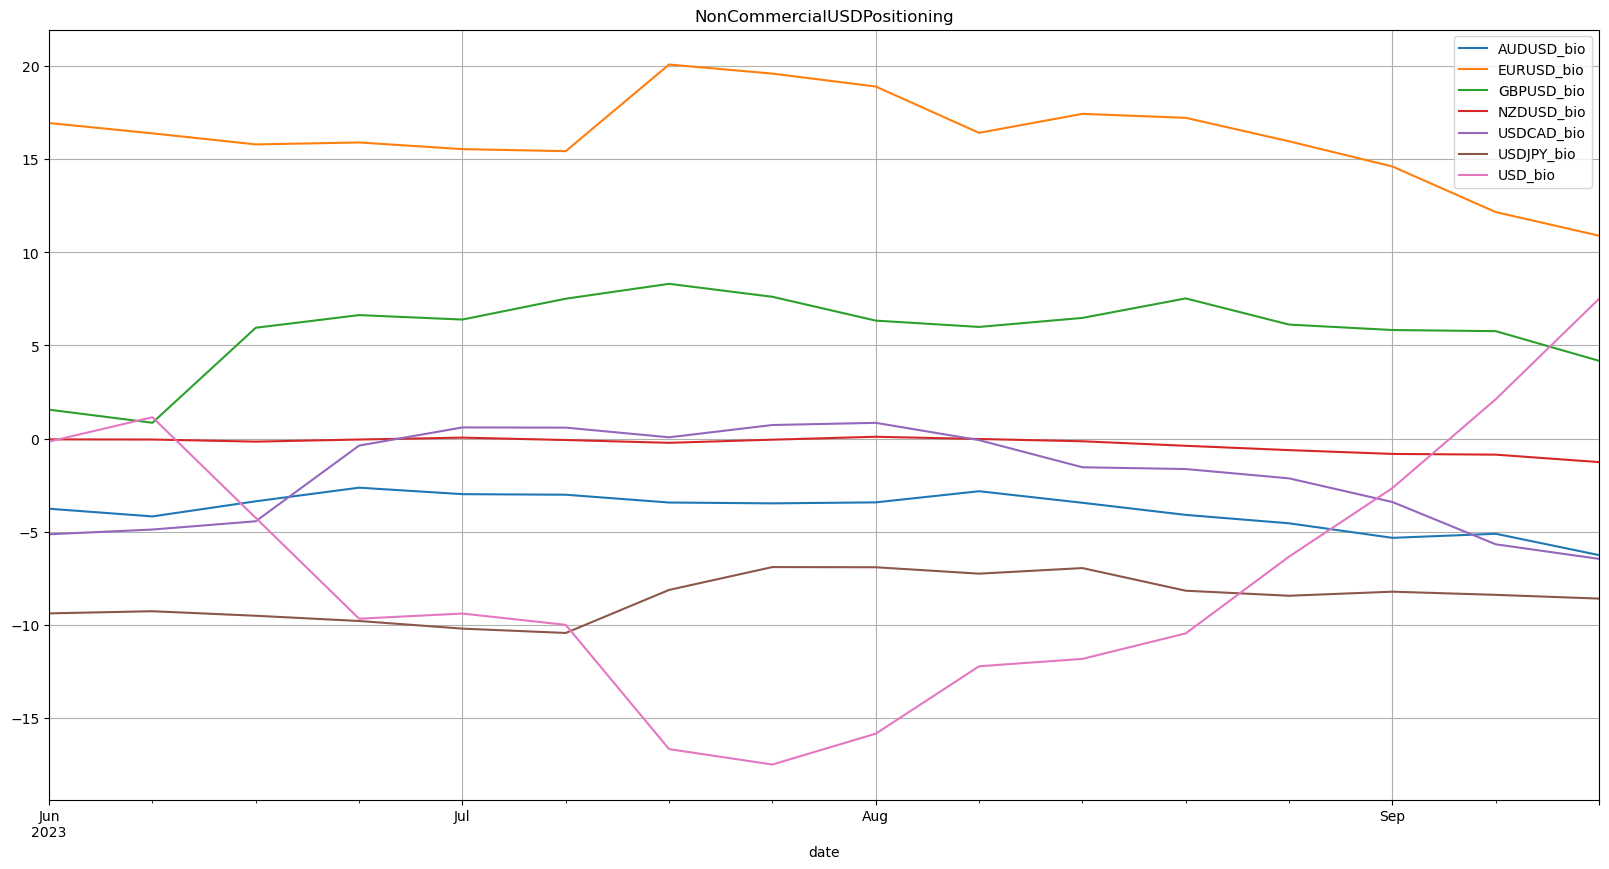

In [75]:
whole.iloc[-300:, arr == 0].plot(figsize = (20,10), grid = True, title = 'NonCommercialUSDPositioning', kind = 'line')
whole.iloc[-10:, arr == 0].tail(10).T

In [95]:
rates['TU1'].tail(20).append(rates['TU1'].describe()).style.format('{:,.1f}')

C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\2489411294.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates['TU1'].tail(20).append(rates['TU1'].describe()).style.format('{:,.1f}')


In [94]:
rates['FV1'].tail(20).append(rates['FV1'].describe()).style.format('{:,.1f}')

C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\626533187.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates['FV1'].tail(20).append(rates['FV1'].describe()).style.format('{:,.1f}')


<AxesSubplot:xlabel='date'>

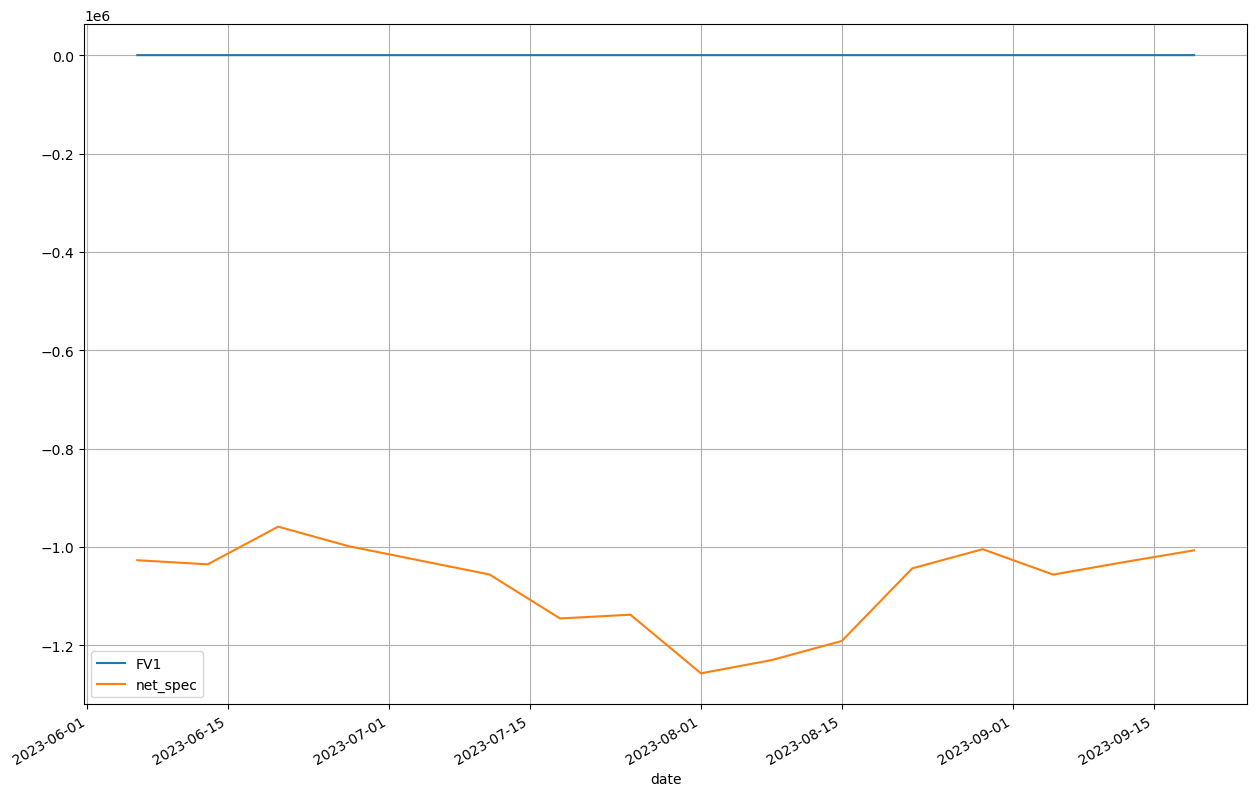

In [79]:
rates['FV1'].iloc[:, [0,3]].plot(figsize = (15,10), grid = True)

In [96]:
rates['TY1'].tail(20).append(rates['TY1'].describe()).style.format('{:,.1f}')

C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\1870666566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates['TY1'].tail(20).append(rates['TY1'].describe()).style.format('{:,.1f}')


<module 'matplotlib.pyplot' from 'C:\\Users\\CP85VC\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

AUDUSD


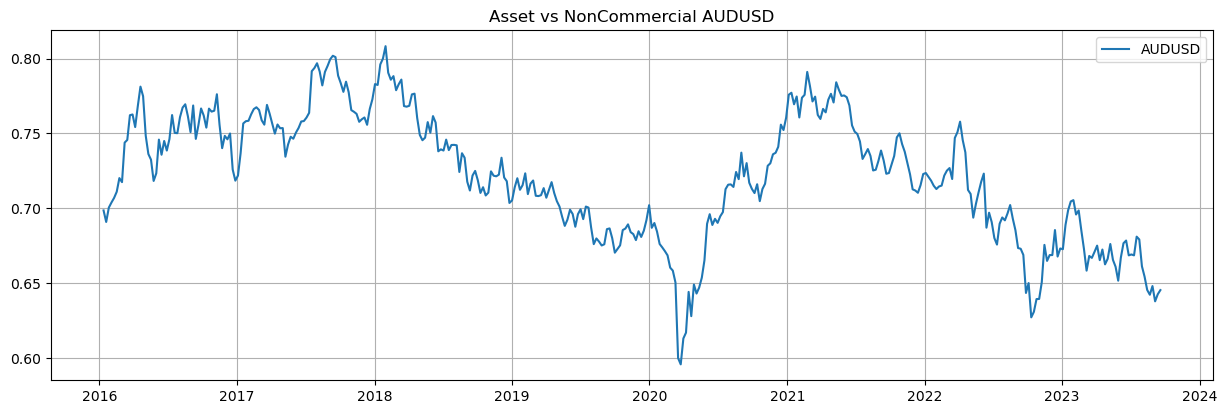

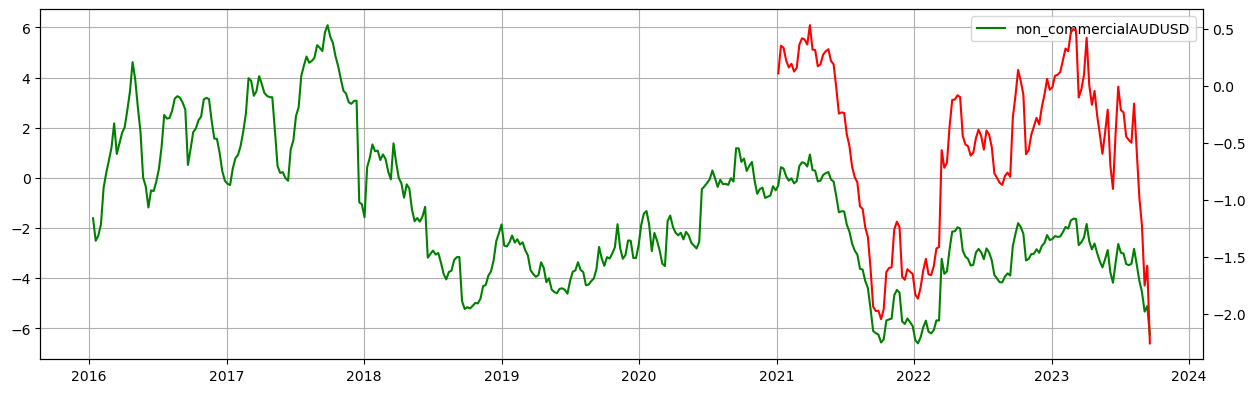

EURUSD


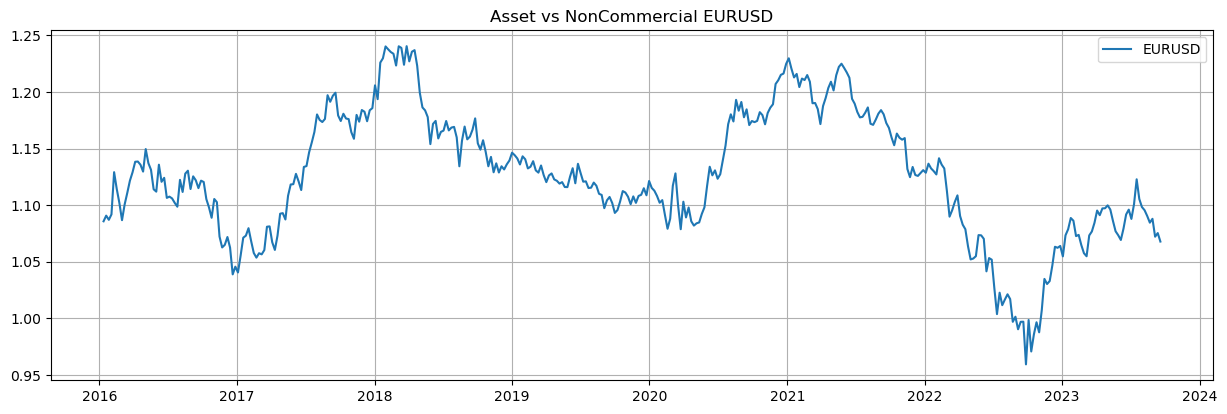

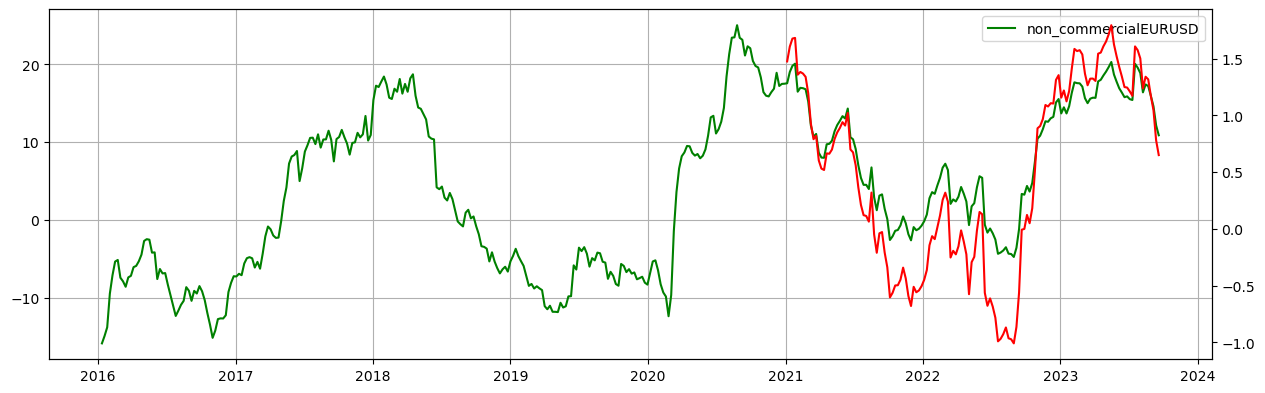

GBPUSD


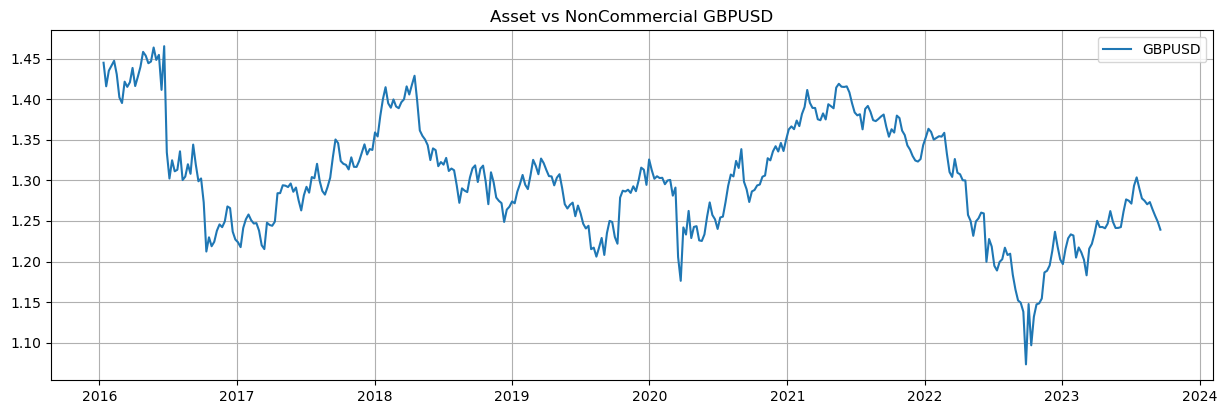

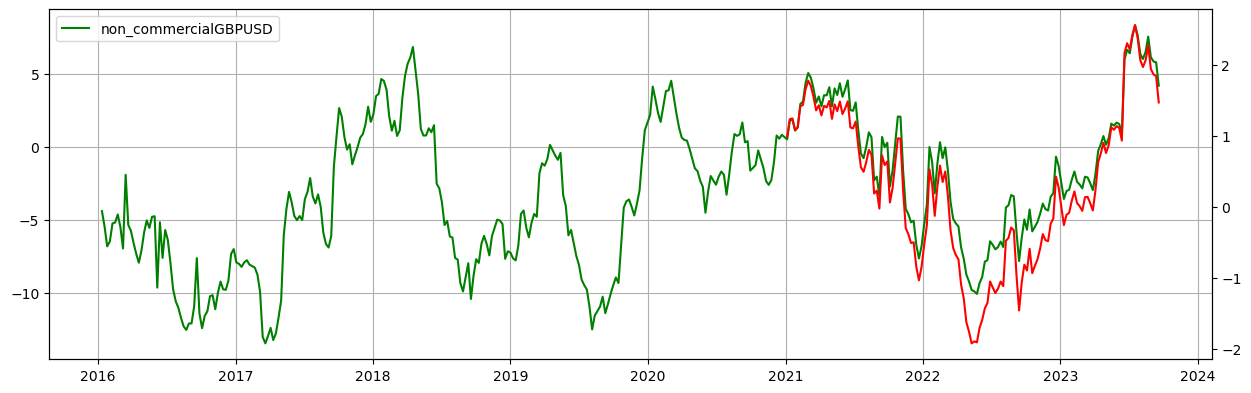

NZDUSD


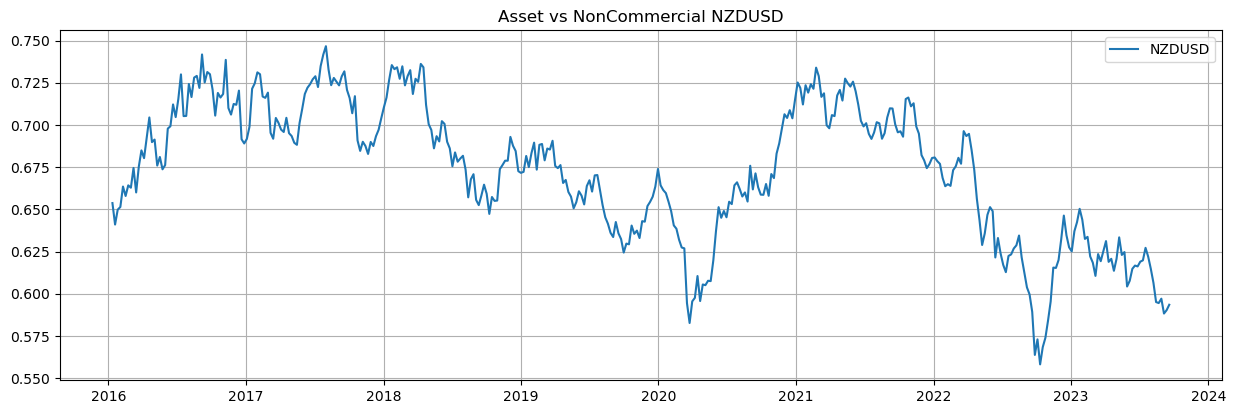

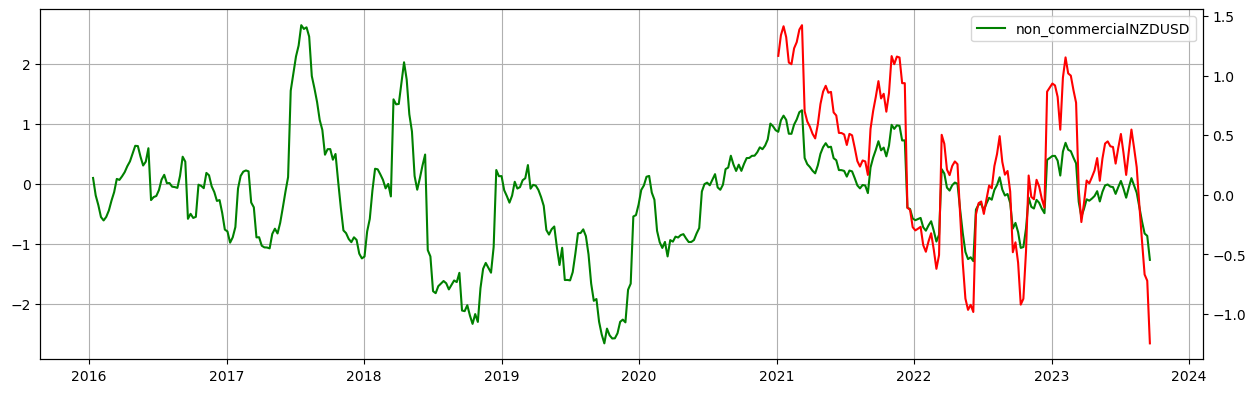

USDCAD


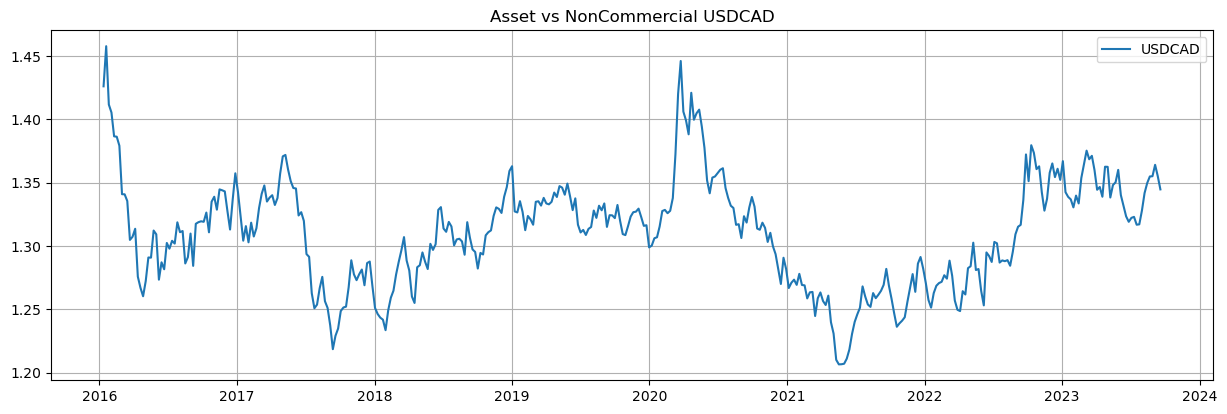

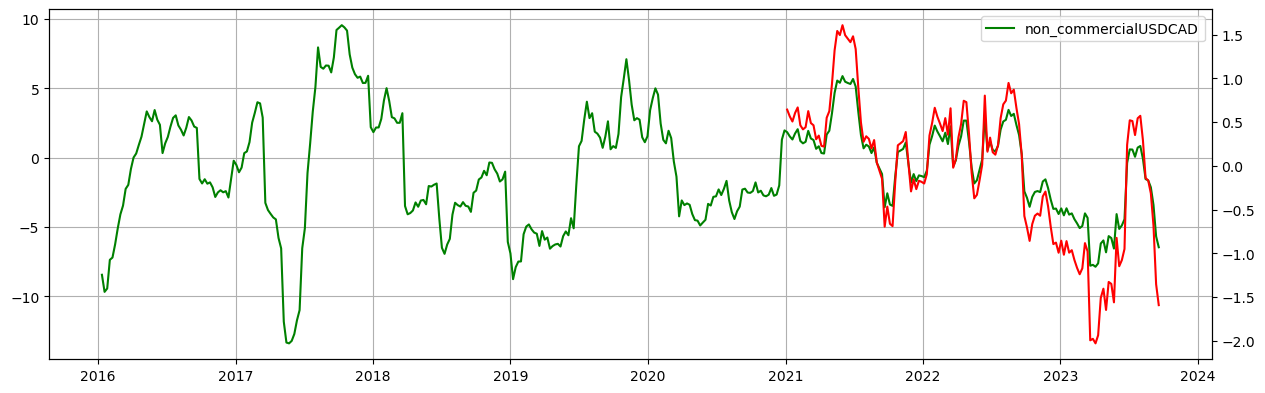

USDJPY


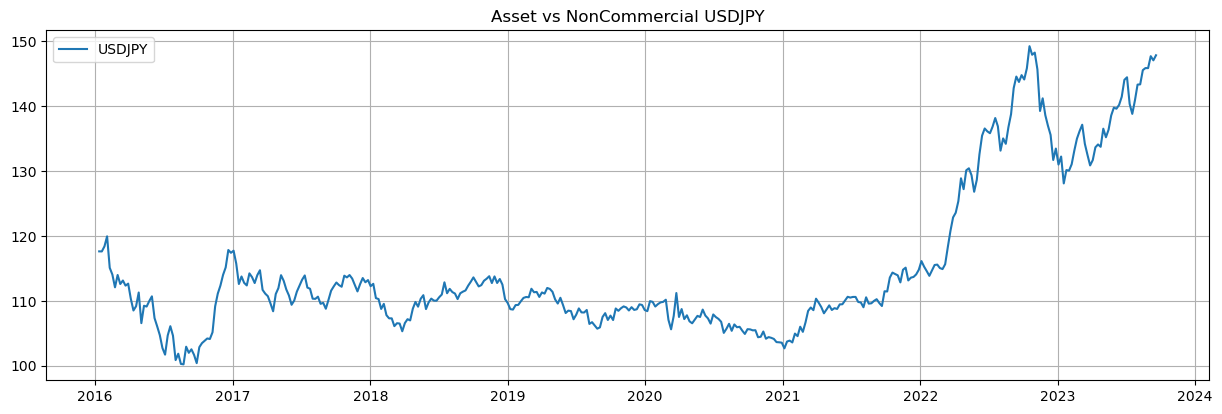

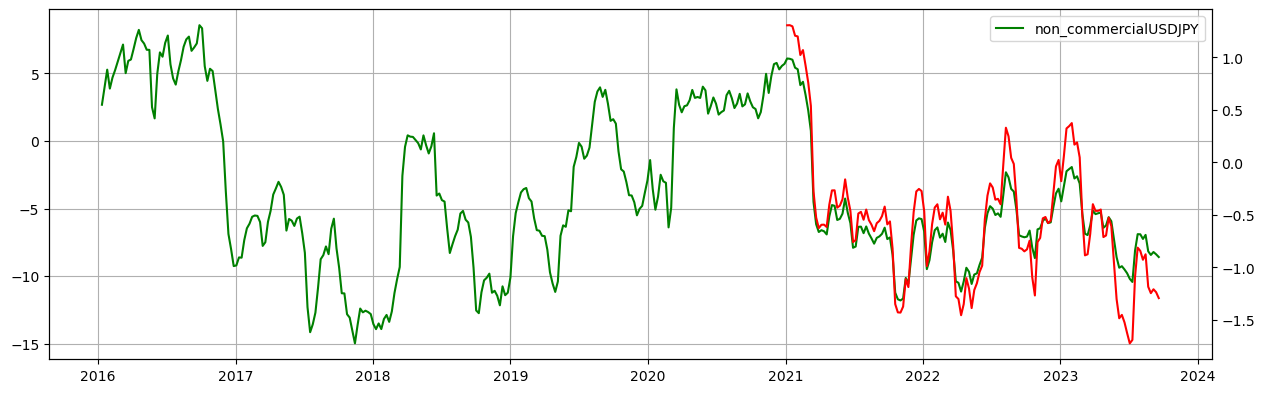

In [17]:
from importlib import reload
reload(plt)

def plot(d):       
    
    '''The 0th column is prices,  
    the 7 (ie 6th) is billions spec, the 6 (ie 5th) is z score
    2nd chart left axis, right axis is z score'''
    
    y = (d.iloc[:, 0], d.iloc[:,6], d.iloc[:,5])

    plt.figure(figsize = (15,10))
    plt.subplot(211) # 1st plot settings start here: (*nrows*, *ncols*, *index*/position)
    
    #plot underlying security
    plt.plot(y[0], lw = 1.5, label = d.columns[0])
    plt.grid(True)
    plt.legend(loc=0)
    plt.axis('tight')
    

    plt.title('Asset vs NonCommercial '+ str(d.columns[0]))
    
    #now plot specs and zscore
    fig, ax1 = plt.subplots(figsize=(15,10)) # chart two series with different scales

    plt.subplot(212) # 2nd plot settings start here:
    
    
    plt.plot(y[1], 'g', lw = 1.5, label = 'non_commercial'+str(d.columns[0]))#plt.plot(y[:, 1], 'g', lw = 1.5, label = 'spec')
    #this has bug, double label on left y# plt.twinx().plot(y[1], 'g', lw = 1.5, label = 'non_commercial'+str(d.columns[0]))#plt.plot(y[:, 1], 'g', lw = 1.5, label = 'spec')
    plt.grid(True)
    plt.legend(loc=0)
    plt.axis('tight')
    plt.twinx().plot(y[2] , 'r', label = 'zscore')
    
    #ax2 = ax1.twinx()
    #plt.plot(y[2], 'r')
    
    # Format x-axis tick labels to show every year and every month
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_minor_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.show()

for i in (fx):
    print(i)
    plot(d = fx[i])

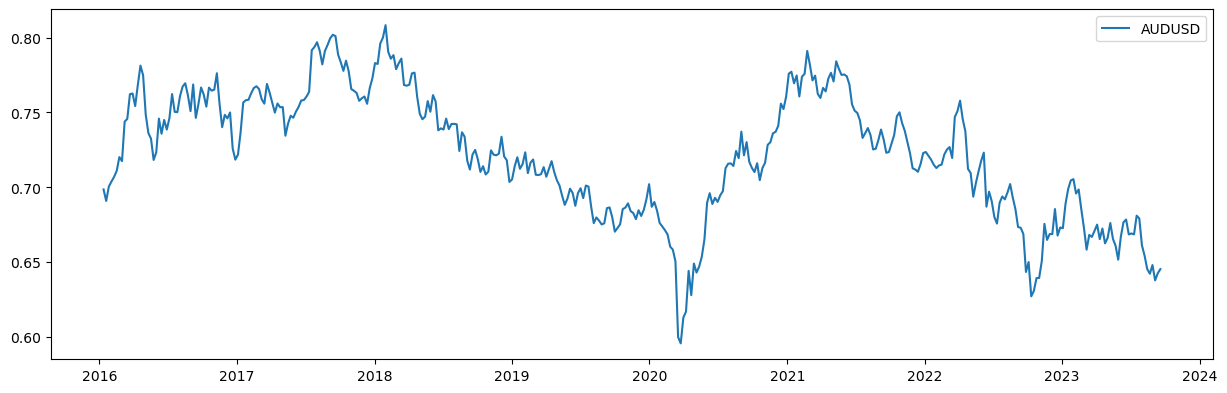

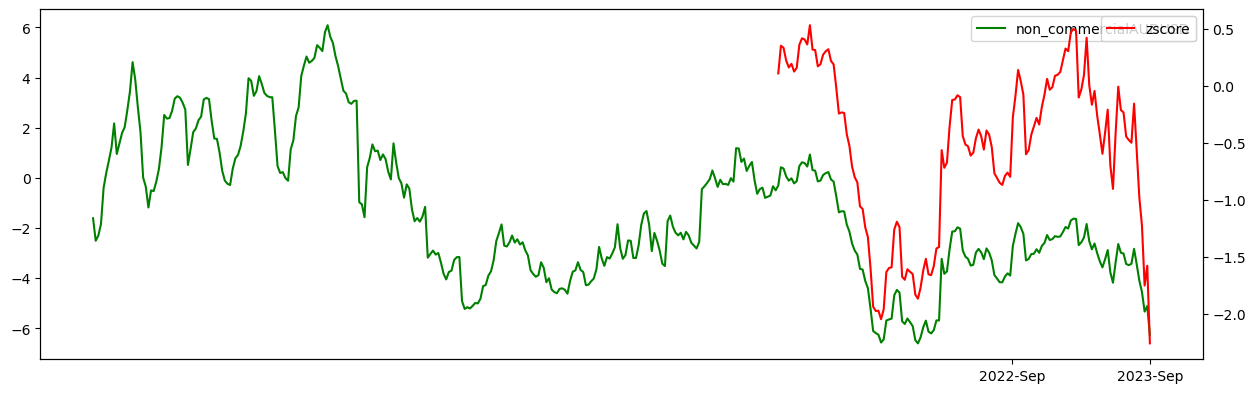

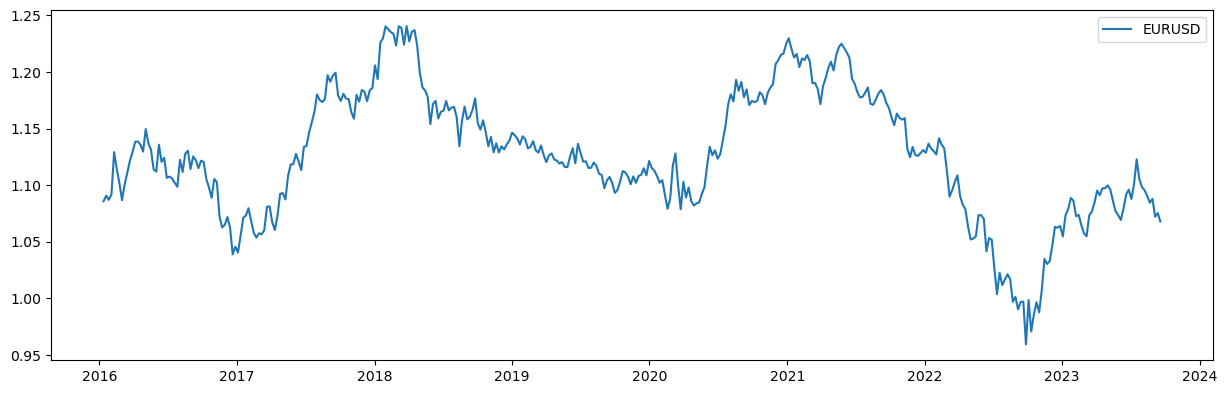

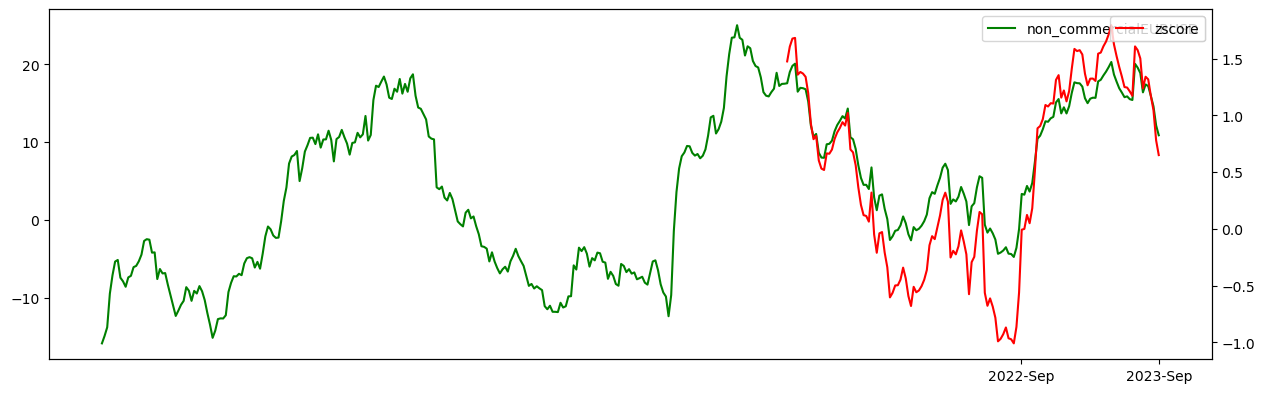

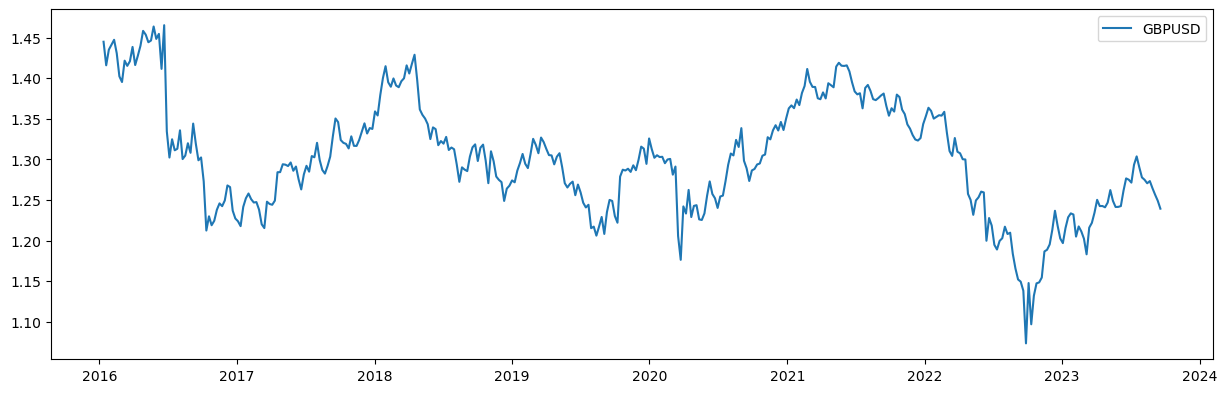

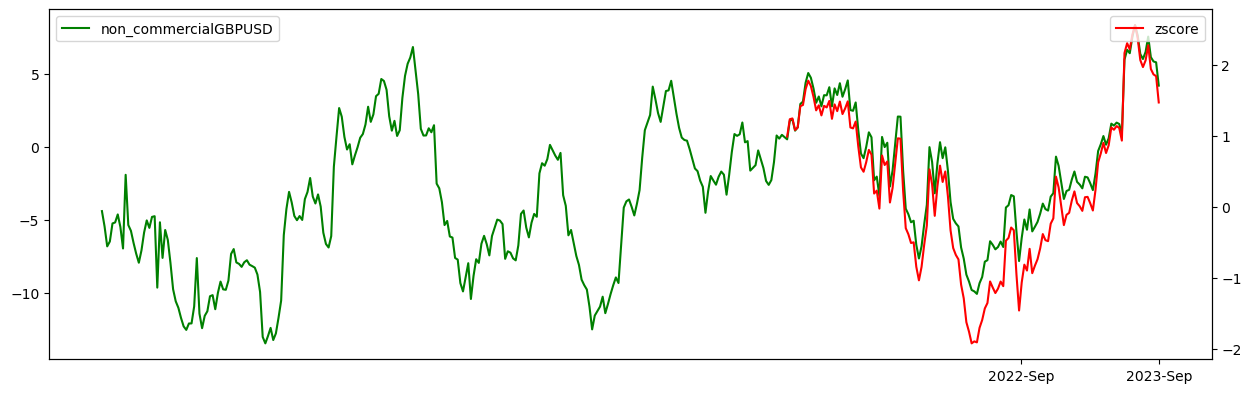

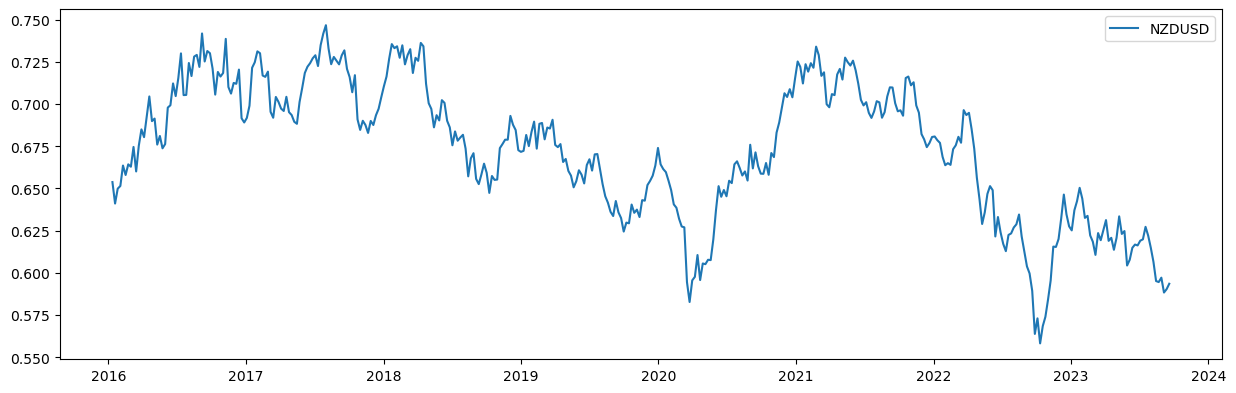

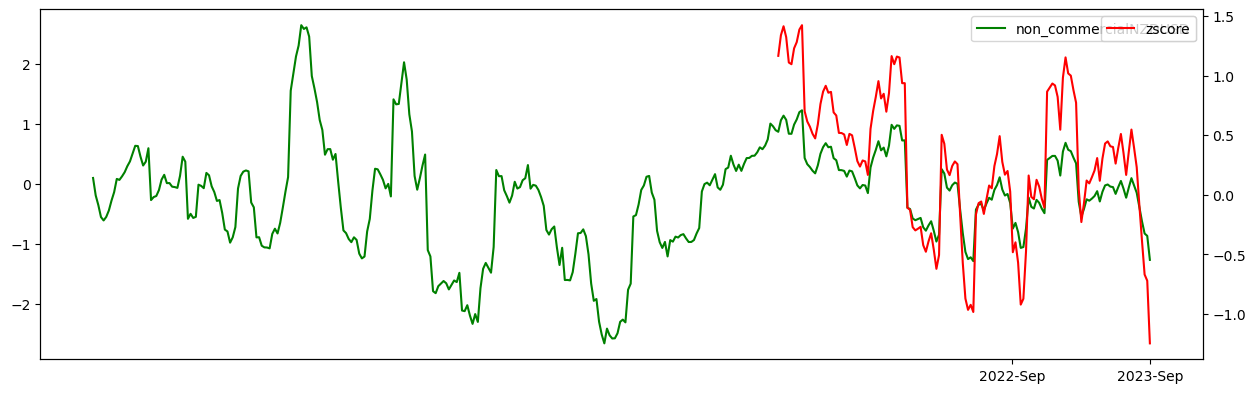

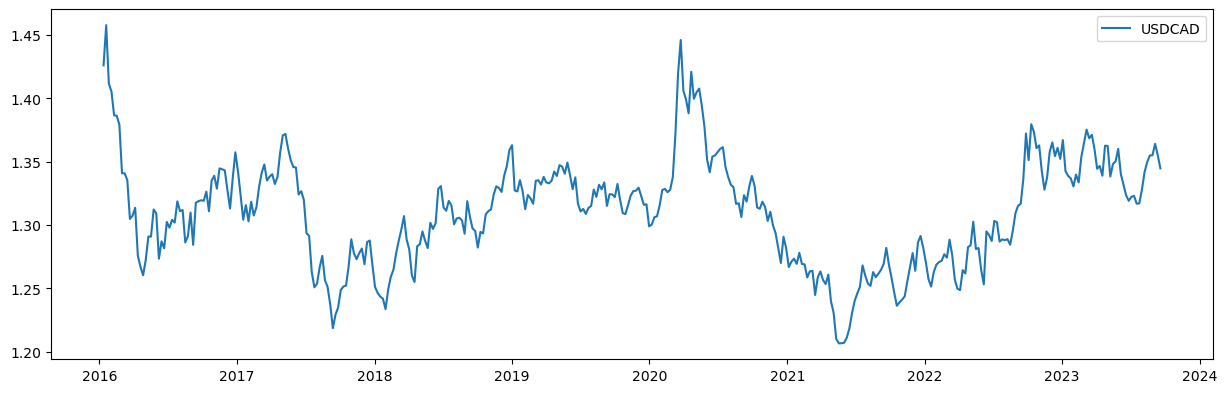

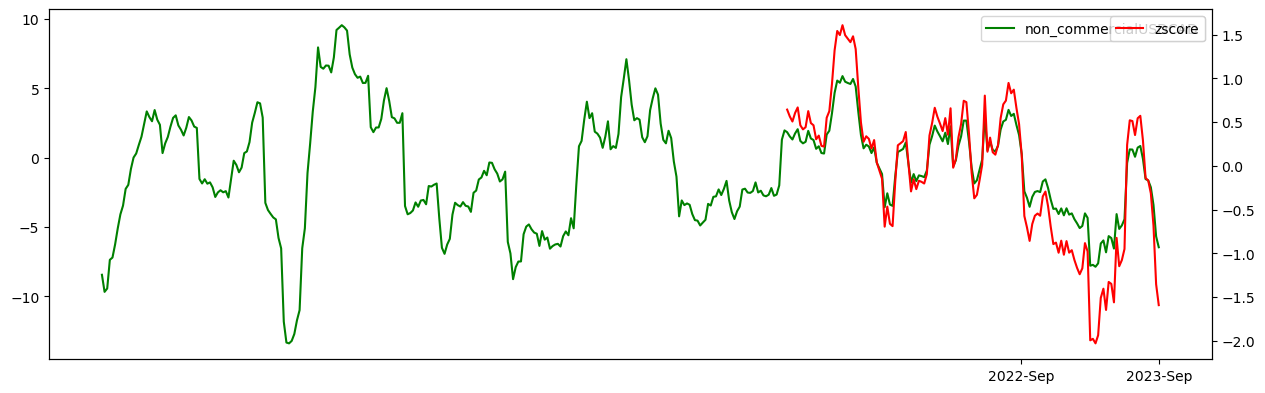

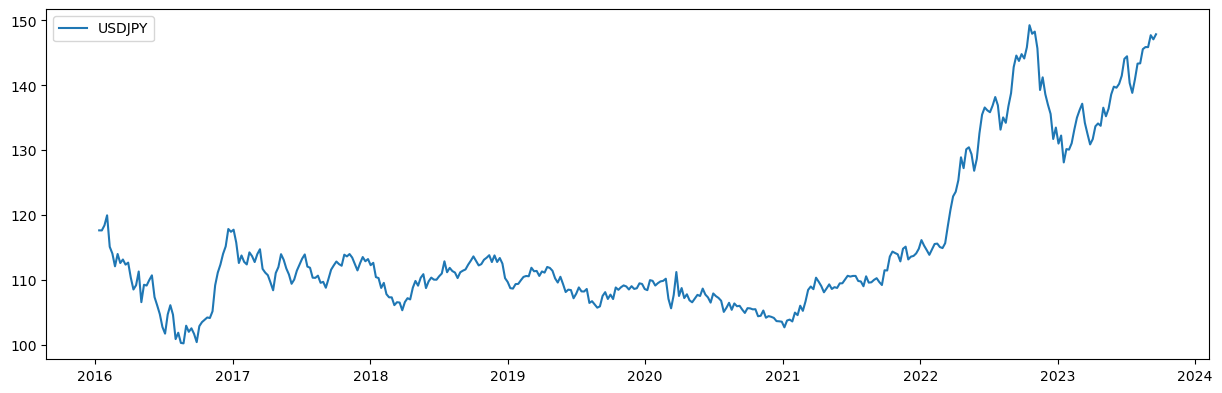

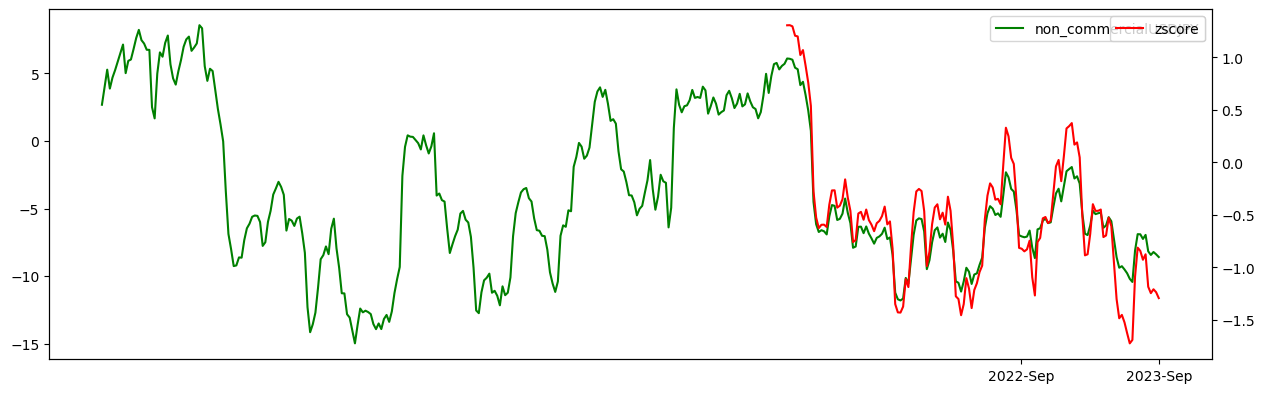

In [18]:
def plot4(d):       
    y = (d.iloc[:, 0], d.iloc[:, 6], d.iloc[:, 5])

    plt.figure(figsize=(15, 10))
    plt.subplot(211)  # 1st plot settings start here: (*nrows*, *ncols*, *index*/position)

    # plot underlying security
    plt.plot(y[0], lw=1.5, label=d.columns[0])
    plt.legend(loc=0)
    plt.axis('tight')

    # now plot specs and zscore
    fig, ax1 = plt.subplots(figsize=(15, 10))  # chart two series with different scales

    plt.subplot(212)  # 2nd plot settings start here:

    plt.plot(y[1], 'g', lw=1.5, label='non_commercial' + str(d.columns[0]))
    plt.legend(loc=0)
    plt.axis('tight')
    ax2 = plt.twinx()
    ax2.plot(y[2], 'r', label='zscore')
    plt.legend(loc=1)

    # Set the x-axis tick labels
    x_values = d.index[-1], d.index[-1] - pd.DateOffset(months=12)
    x_labels = [x.strftime('%Y-%b') for x in x_values]
    plt.xticks(x_values, x_labels)
    
    plt.show()

# Assuming you have a DataFrame 'df' with the data to plot
# Call the function plot() with the DataFrame as an argument



# Assuming you have a DataFrame 'df' with the data to plot
# Call the function plot() with the DataFrame as an argument
for i in fx:
    plot4(d = fx[i])


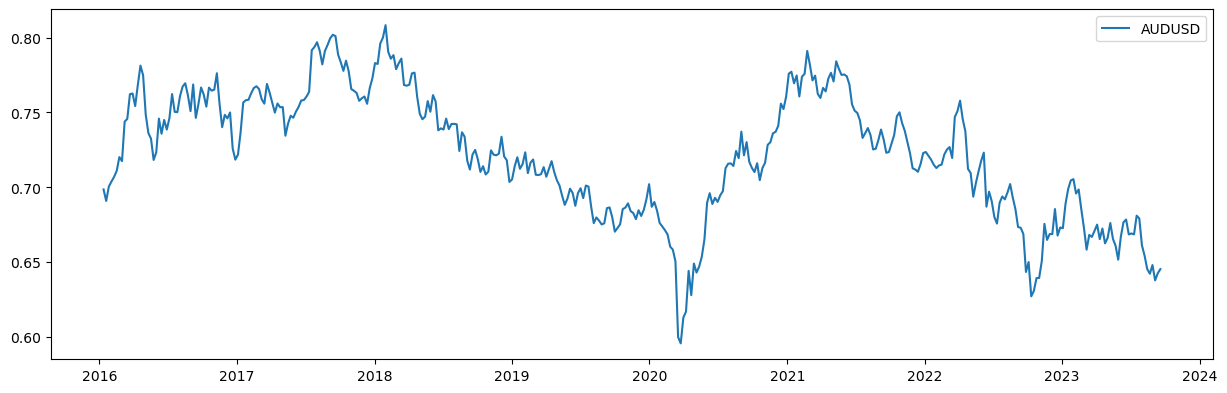

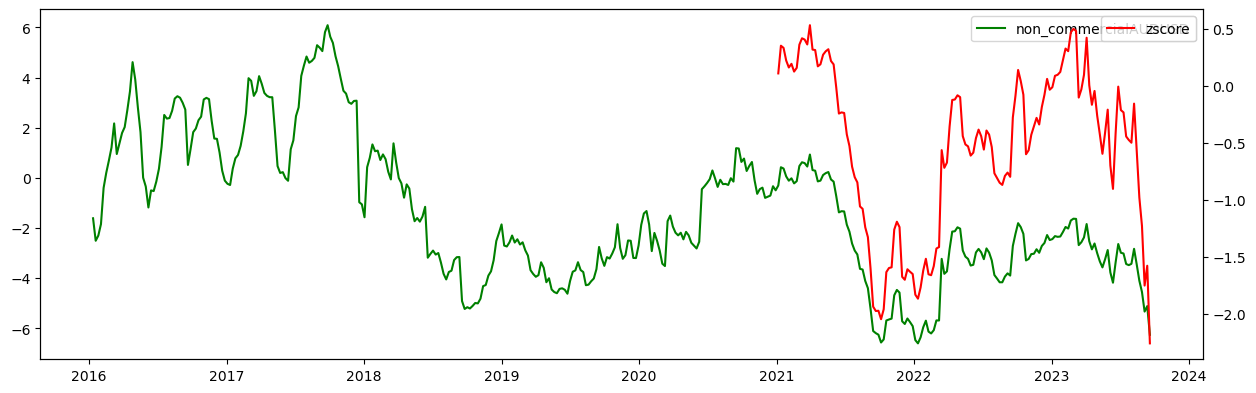

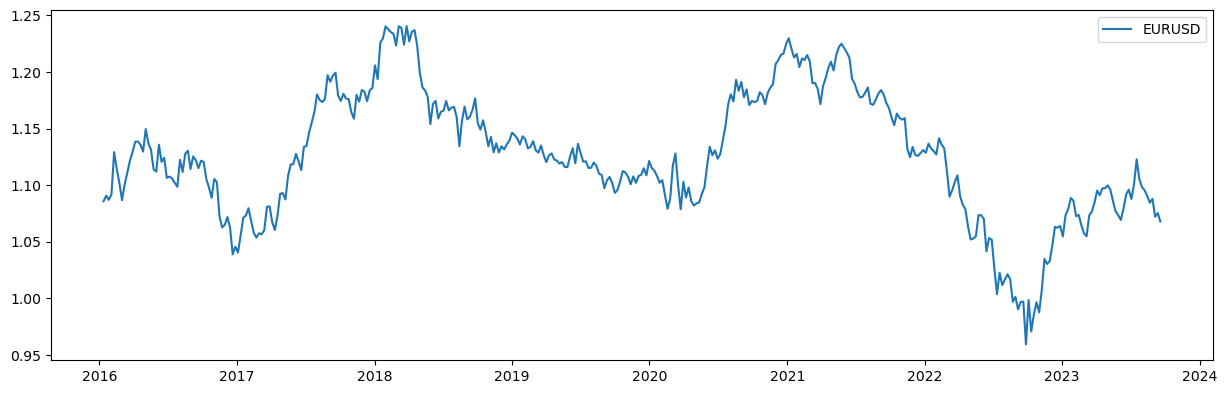

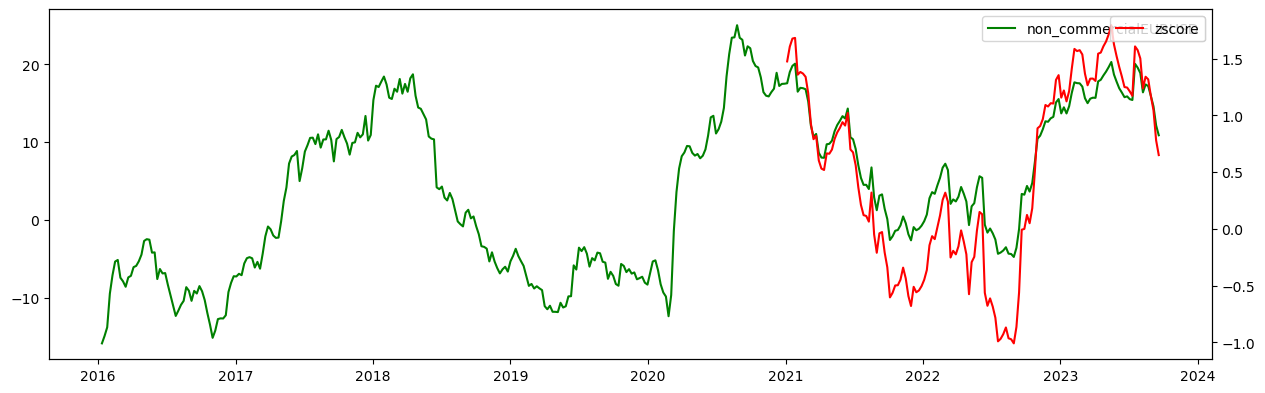

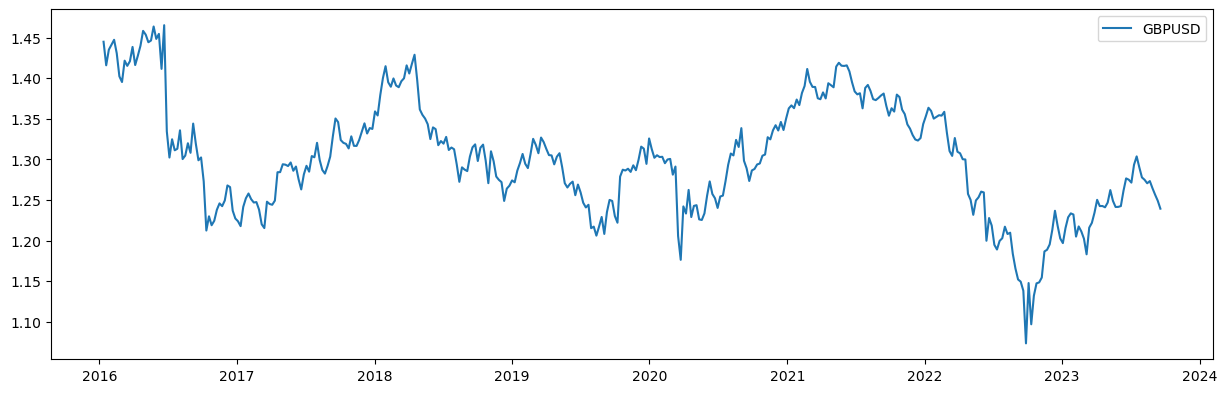

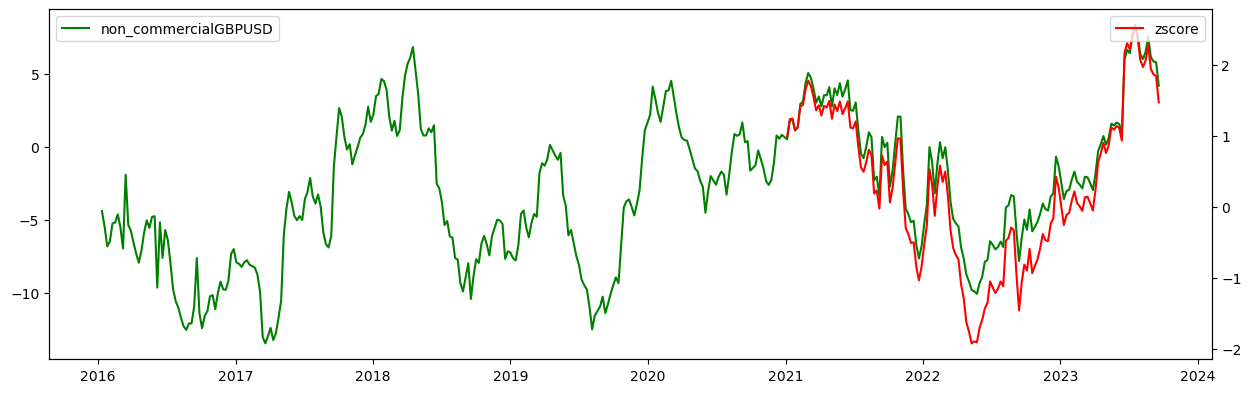

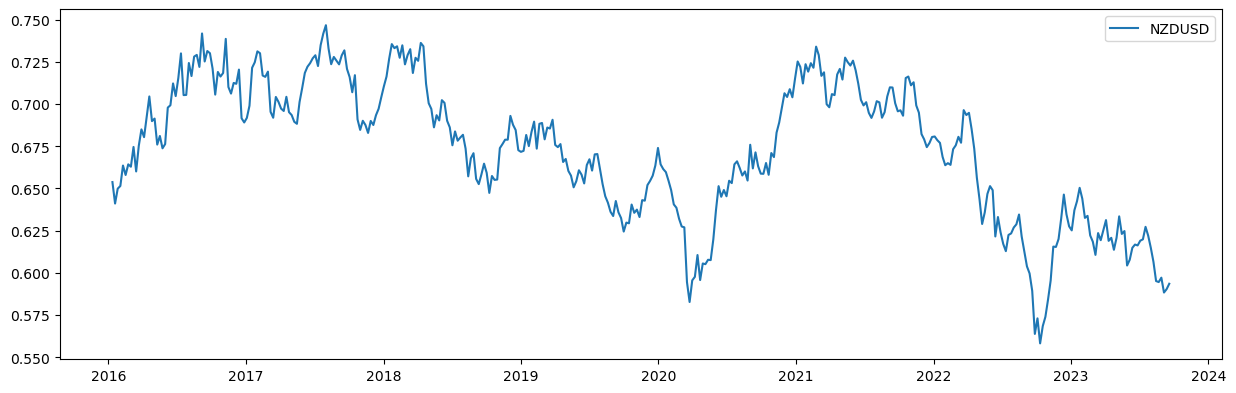

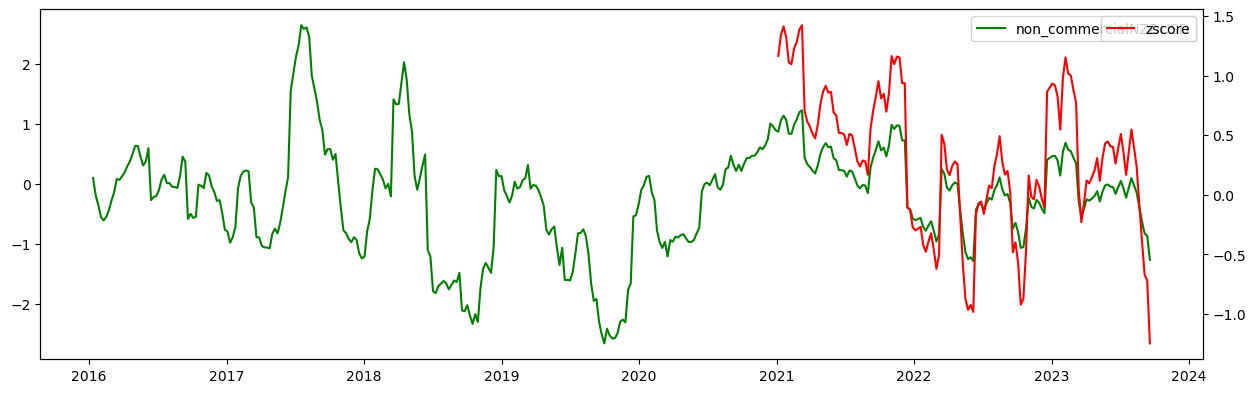

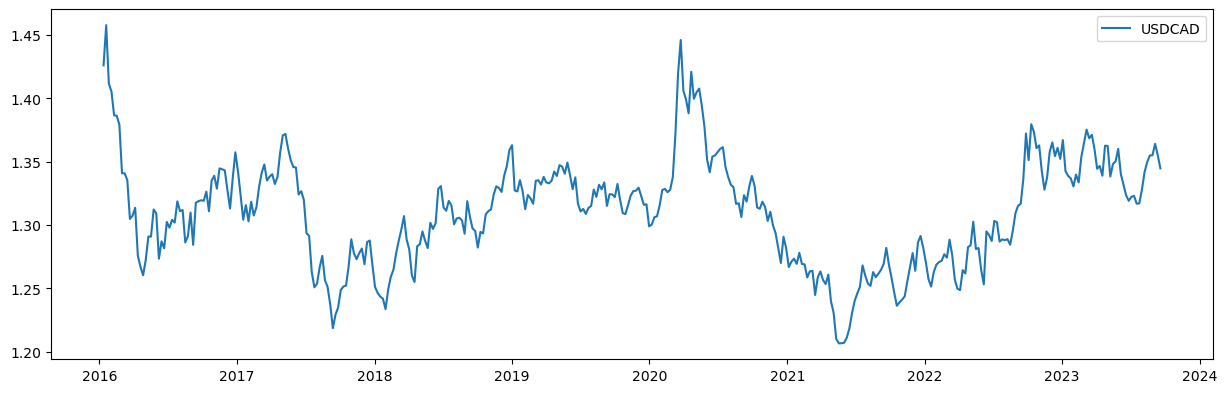

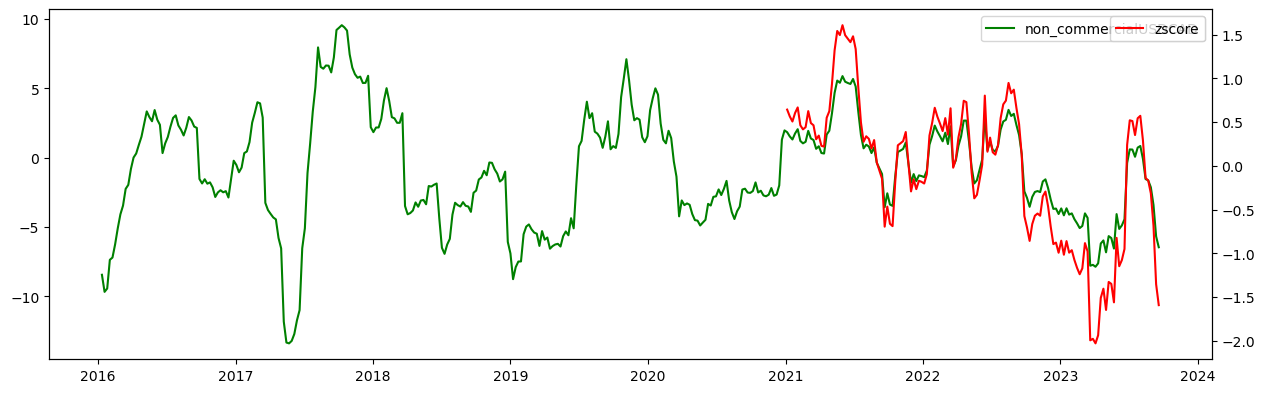

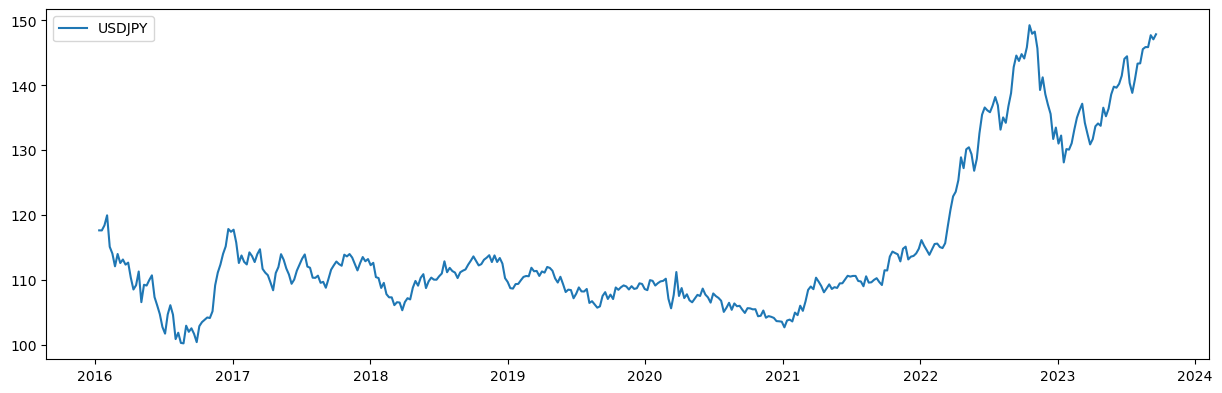

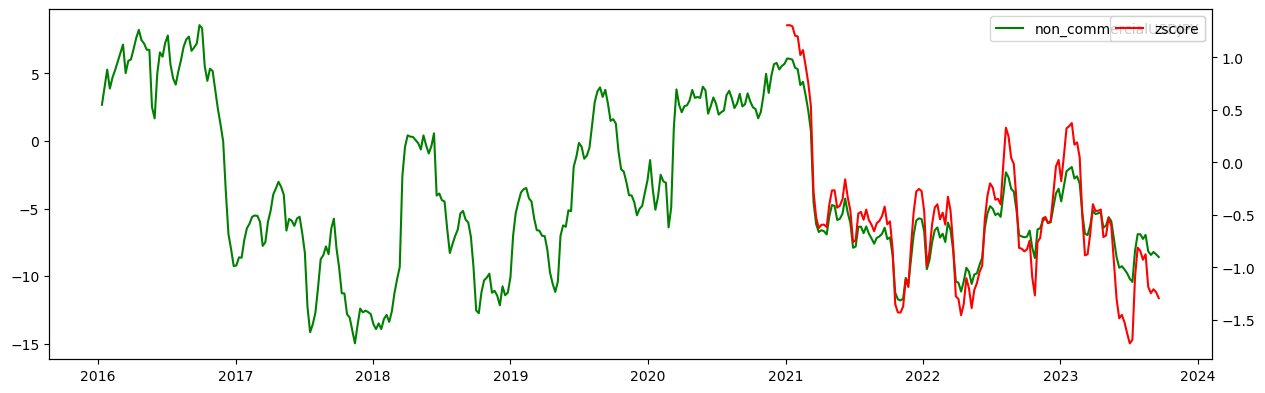

In [19]:
def plot3(d):       
    y = (d.iloc[:, 0], d.iloc[:, 6], d.iloc[:, 5])

    plt.figure(figsize=(15, 10))
    plt.subplot(211)  # 1st plot settings start here: (*nrows*, *ncols*, *index*/position)

    # plot underlying security
    plt.plot(y[0], lw=1.5, label=d.columns[0])
    plt.legend(loc=0)
    plt.axis('tight')

    # now plot specs and zscore
    fig, ax1 = plt.subplots(figsize=(15, 10))  # chart two series with different scales

    plt.subplot(212)  # 2nd plot settings start here:

    plt.plot(y[1], 'g', lw=1.5, label='non_commercial' + str(d.columns[0]))
    plt.legend(loc=0)
    plt.axis('tight')
    ax2 = plt.twinx()
    ax2.plot(y[2], 'r', label='zscore')
    plt.legend(loc=1)

    # Set the major locator and date format for the x-axis
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    
    
    plt.show()

# Assuming you have a DataFrame 'df' with the data to plot
# Call the function plot() with the DataFrame as an argument

for i in fx:
    plot3(d = fx[i])




TU1


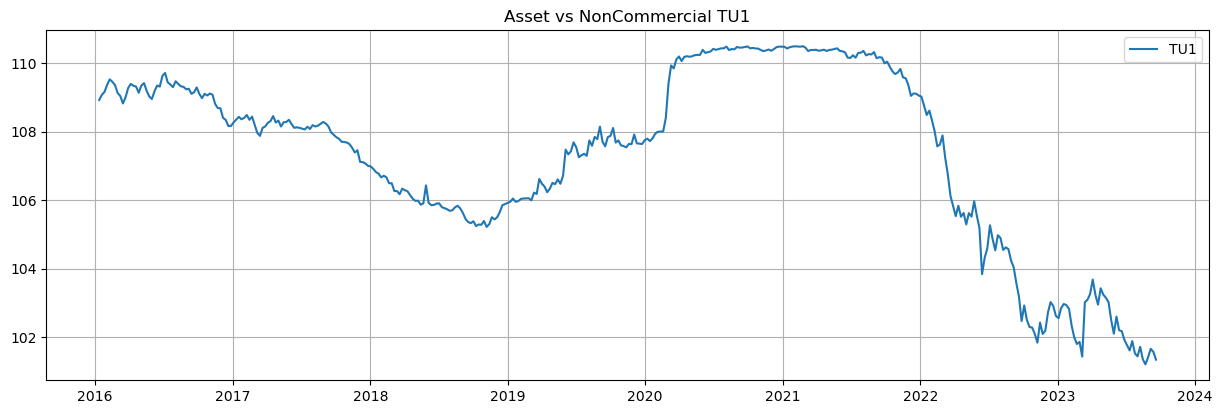

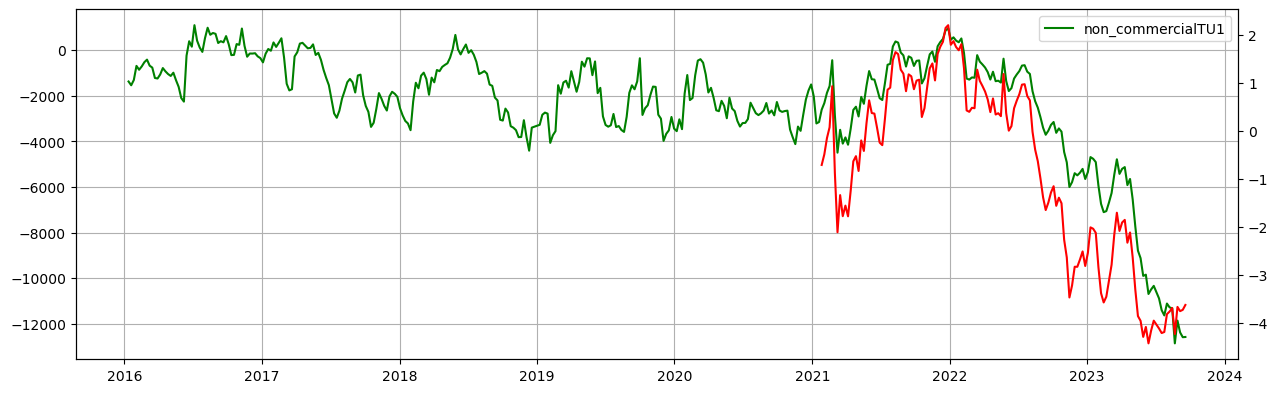

FV1


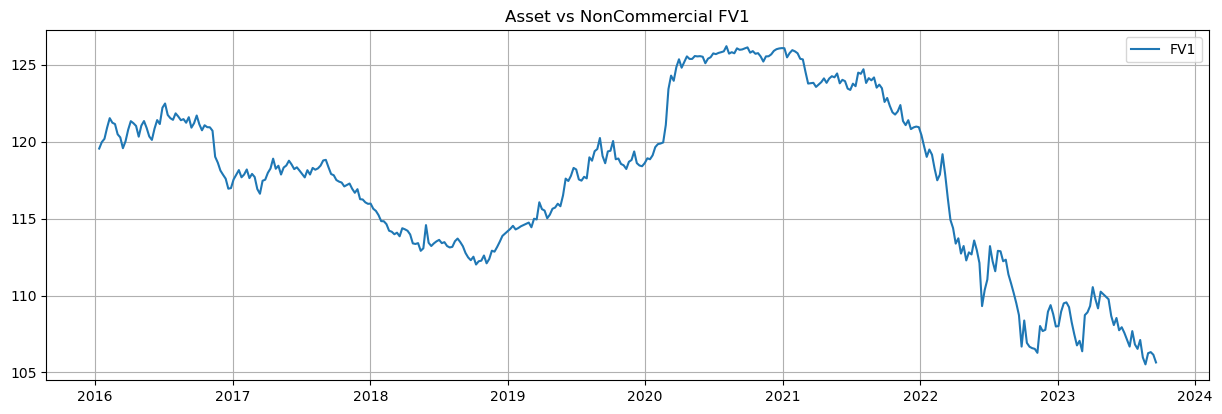

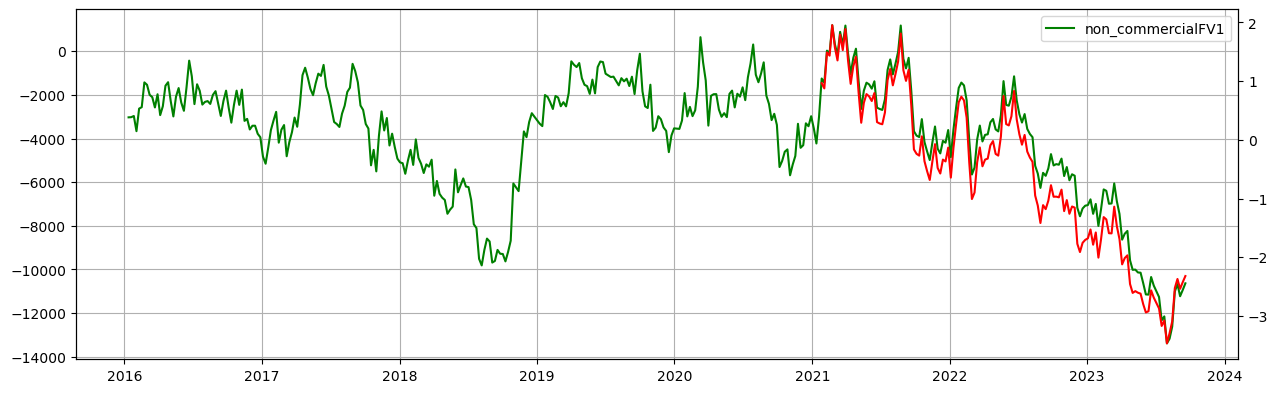

TY1


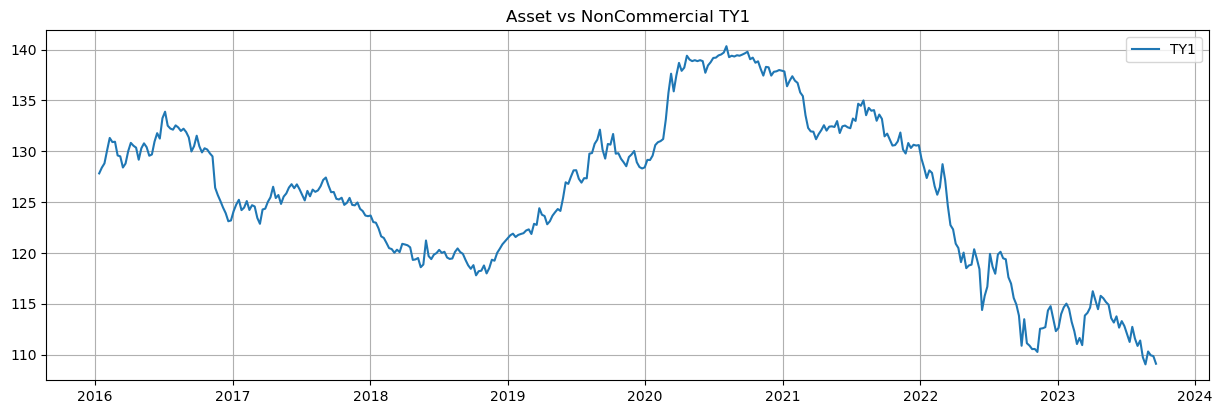

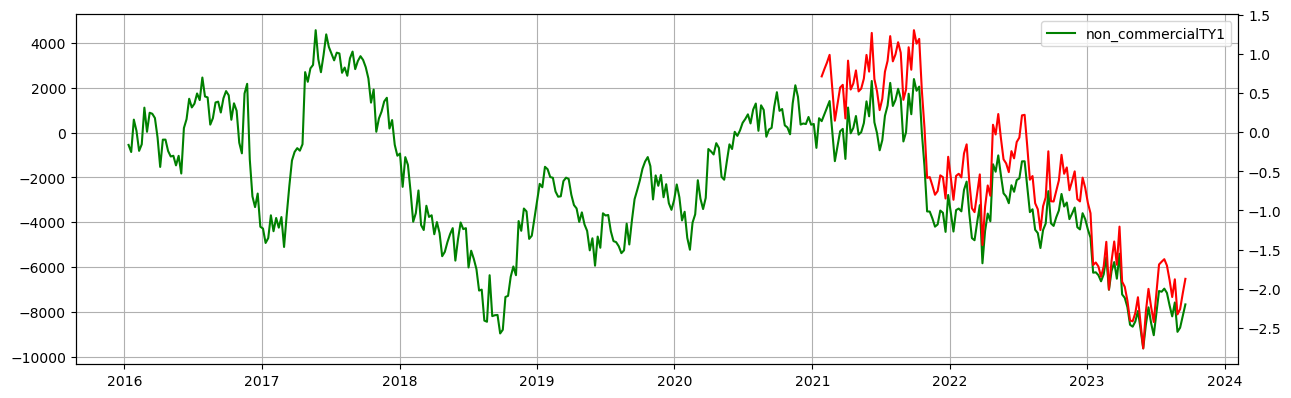

US1


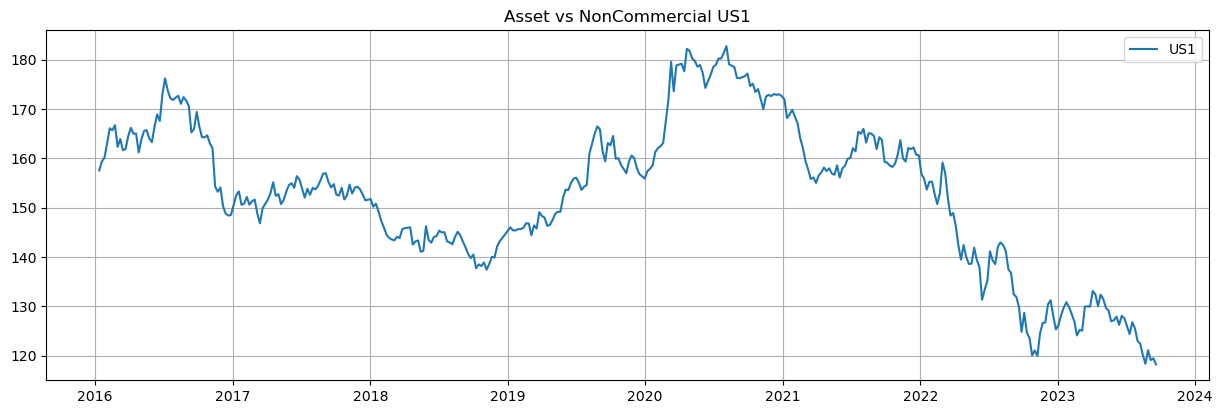

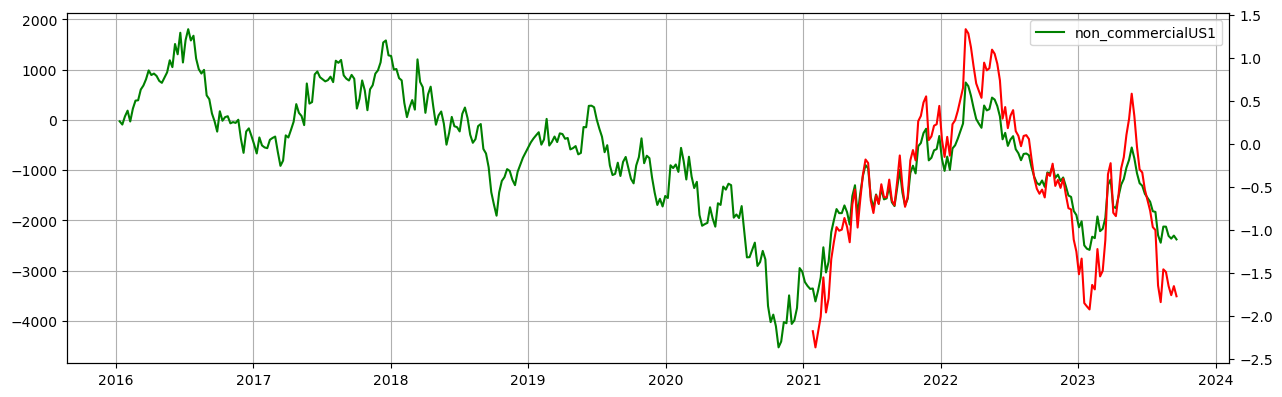

In [20]:
for i in (rates):
    print(i)
    plot(d = rates[i])

In [21]:
print('AssetMan:')
stonks_AM['ES1'].tail(20)#.resample('M').mean().loc['2021':].tail(14)
print('-'*50)
print('HF:')
stonks_HF['ES1'].tail(20)#.resample('M').last().loc['2021':].tail(14)

AssetMan:


ES1  TFF1NAIL Index  TFF1NAIS Index   net_spec  weekly_change  \
date                                                                            
2023-05-02 4,136.75    1,024,702.00      431,620.00 593,082.00       8,608.00   
2023-05-09 4,134.00    1,022,048.00      425,230.00 596,818.00       3,736.00   
2023-05-16 4,123.00    1,044,159.00      431,121.00 613,038.00      16,220.00   
2023-05-23 4,158.75    1,050,328.00      422,716.00 627,612.00      14,574.00   
2023-05-30 4,215.00    1,044,448.00      416,552.00 627,896.00         284.00   
2023-06-06 4,289.75    1,049,792.00      383,666.00 666,126.00      38,230.00   
2023-06-13 4,416.75    1,096,444.00      332,825.00 763,619.00      97,493.00   
2023-06-20 4,434.75    1,117,899.00      319,369.00 798,530.00      34,911.00   
2023-06-27 4,418.75    1,092,669.00      338,708.00 753,961.00     -44,569.00   
2023-07-11 4,473.50    1,083,884.00      323,761.00 760,123.00       6,162.00   
2023-07-18 4,587.75    1,123,247.00      303,460.00 819,787.00      59,664.00   
2023-07-25 4,596.00    1,122,082.00      319,776.00 802,306.00     -17,481.00   
2023-08-01 4,601.25    1,124,571.00      304,219.00 820,352.00      18,046.00   
2023-08-08 4,518.50    1,093,720.00      319,370.00 774,350.00     -46,002.00   
2023-08-15 4,454.00    1,103,269.00      323,742.00 779,527.00       5,177.00   
2023-08-22 4,399.25    1,108,490.00      353,508.00 754,982.00     -24,545.00   
2023-08-29 4,506.75    1,094,797.00      339,390.00 755,407.00         425.00   
2023-09-05 4,502.50    1,107,940.00      327,801.00 780,139.00      24,732.00   
2023-09-12 4,513.75    1,098,908.00      317,610.00 781,298.00       1,159.00   
2023-09-19 4,490.00    1,165,542.00      301,861.00 863,681.00      82,383.00   

            z_score    ES1_bio  ES1_week_chng_bio  
date                                               
2023-05-02    -0.19 245,343.20           6,103.38  
2023-05-09    -0.17 246,724.56           1,381.36  
2023-05-16    -0.09 252,755.57           6,031.01  
2023-05-23    -0.03 261,008.14           8,252.57  
2023-05-30    -0.03 264,658.16           3,650.02  
2023-06-06     0.15 285,751.40          21,093.24  
2023-06-13     0.62 337,271.42          51,520.02  
2023-06-20     0.78 354,128.09          16,856.67  
2023-06-27     0.56 333,156.52         -20,971.57  
2023-07-11     0.59 340,041.02           6,884.51  
2023-07-18     0.87 376,097.78          36,056.76  
2023-07-25     0.78 368,739.84          -7,357.94  
2023-08-01     0.86 377,464.46           8,724.63  
2023-08-08     0.63 349,890.05         -27,574.42  
2023-08-15     0.65 347,201.33          -2,688.72  
2023-08-22     0.53 332,135.46         -15,065.87  
2023-08-29     0.53 340,443.05           8,307.59  
2023-09-05     0.64 351,257.58          10,814.54  
2023-09-12     0.64 352,658.38           1,400.80  
2023-09-19     1.04 387,792.77          35,134.38

--------------------------------------------------
HF:


ES1  TFF1NLFL Index  TFF1NLFS Index    net_spec  \
date                                                              
2023-05-02 4,136.75      134,979.00      602,843.00 -467,864.00   
2023-05-09 4,134.00      138,545.00      651,848.00 -513,303.00   
2023-05-16 4,123.00      127,634.00      628,910.00 -501,276.00   
2023-05-23 4,158.75      164,886.00      682,787.00 -517,901.00   
2023-05-30 4,215.00      185,941.00      716,664.00 -530,723.00   
2023-06-06 4,289.75      181,871.00      758,002.00 -576,131.00   
2023-06-13 4,416.75      173,084.00      711,649.00 -538,565.00   
2023-06-20 4,434.75      126,222.00      506,645.00 -380,423.00   
2023-06-27 4,418.75      136,200.00      451,823.00 -315,623.00   
2023-07-11 4,473.50      173,135.00      480,271.00 -307,136.00   
2023-07-18 4,587.75      174,266.00      559,419.00 -385,153.00   
2023-07-25 4,596.00      157,662.00      560,994.00 -403,332.00   
2023-08-01 4,601.25      147,697.00      530,202.00 -382,505.00   
2023-08-08 4,518.50      171,013.00      498,539.00 -327,526.00   
2023-08-15 4,454.00      146,415.00      442,447.00 -296,032.00   
2023-08-22 4,399.25      120,216.00      452,038.00 -331,822.00   
2023-08-29 4,506.75      138,068.00      491,791.00 -353,723.00   
2023-09-05 4,502.50      126,248.00      461,550.00 -335,302.00   
2023-09-12 4,513.75      176,348.00      426,460.00 -250,112.00   
2023-09-19 4,490.00       98,445.00      418,743.00 -320,298.00   

            weekly_change  z_score     ES1_bio  ES1_week_chng_bio  
date                                                               
2023-05-02       7,202.00    -1.93 -193,543.64             912.75  
2023-05-09     -45,439.00    -2.25 -212,199.46         -18,655.82  
2023-05-16      12,027.00    -2.14 -206,676.09           5,523.37  
2023-05-23     -16,625.00    -2.24 -215,382.08          -8,705.98  
2023-05-30     -12,822.00    -2.31 -223,699.74          -8,317.67  
2023-06-06     -45,408.00    -2.61 -247,145.80         -23,446.05  
2023-06-13      37,566.00    -2.30 -237,870.70           9,275.10  
2023-06-20     158,142.00    -1.14 -168,708.09          69,162.61  
2023-06-27      64,800.00    -0.67 -139,465.91          29,242.18  
2023-07-11       8,487.00    -0.60 -137,397.29           2,068.62  
2023-07-18     -78,017.00    -1.15 -176,698.57         -39,301.28  
2023-07-25     -18,179.00    -1.27 -185,371.39          -8,672.82  
2023-08-01      20,827.00    -1.11 -176,000.11           9,371.27  
2023-08-08      54,979.00    -0.71 -147,992.62          28,007.49  
2023-08-15      31,494.00    -0.48 -131,852.65          16,139.97  
2023-08-22     -35,790.00    -0.73 -145,976.79         -14,124.14  
2023-08-29     -21,901.00    -0.89 -159,414.11         -13,437.32  
2023-09-05      18,421.00    -0.75 -150,969.73           8,444.39  
2023-09-12      85,190.00    -0.14 -112,894.30          38,075.42  
2023-09-19     -70,186.00    -0.63 -143,813.80         -30,919.50

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

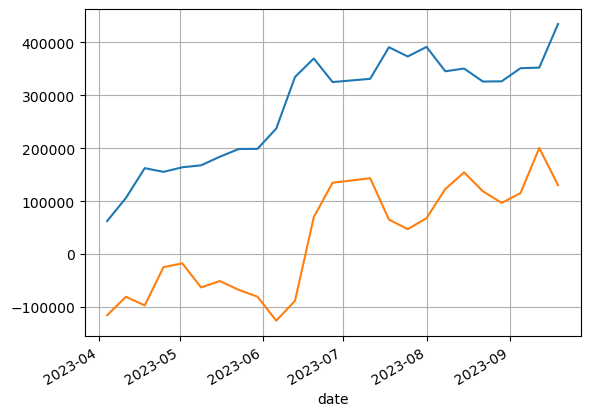

In [22]:
stonks_AM['ES1'].loc['2023-04-01':, 'weekly_change'].cumsum().plot(grid = True)
stonks_HF['ES1'].loc['2023-04-01':, 'weekly_change'].cumsum().plot(grid = True)

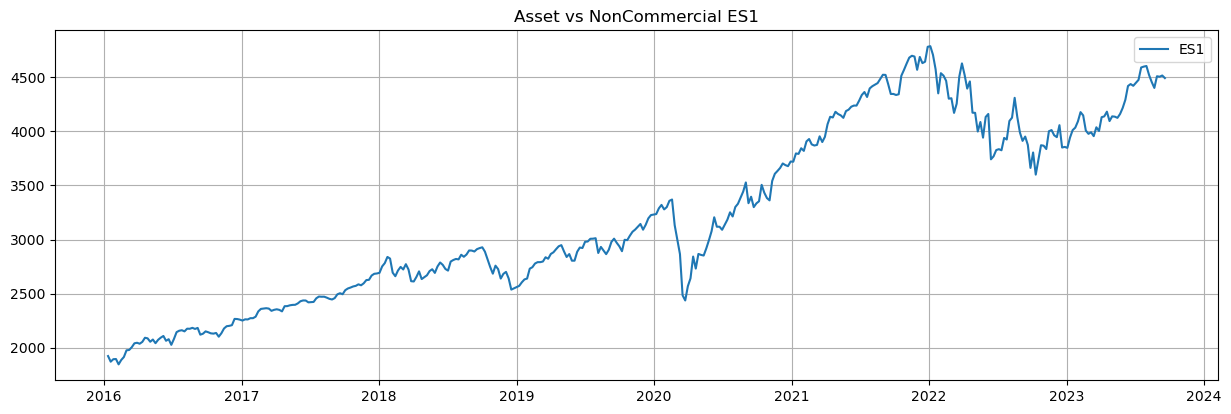

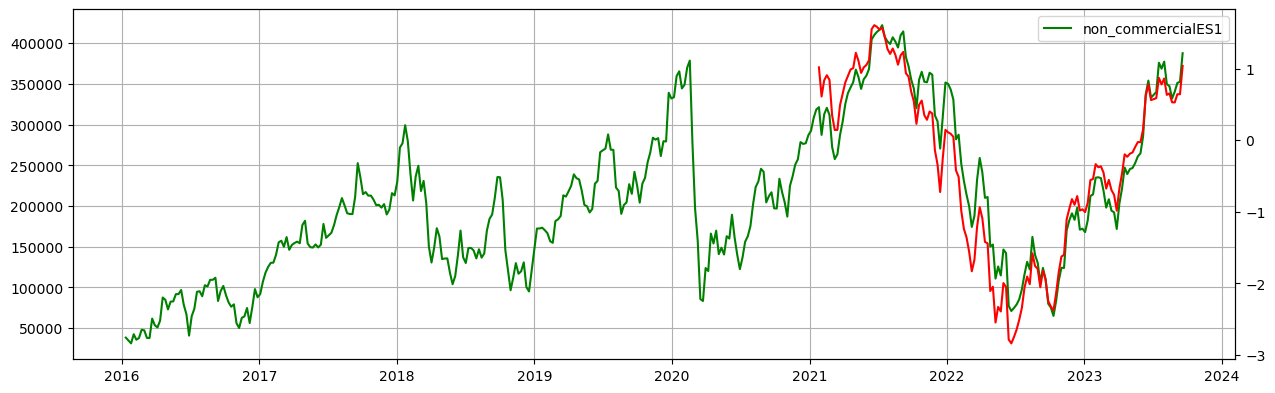

In [23]:
plot(d = stonks_AM['ES1'])

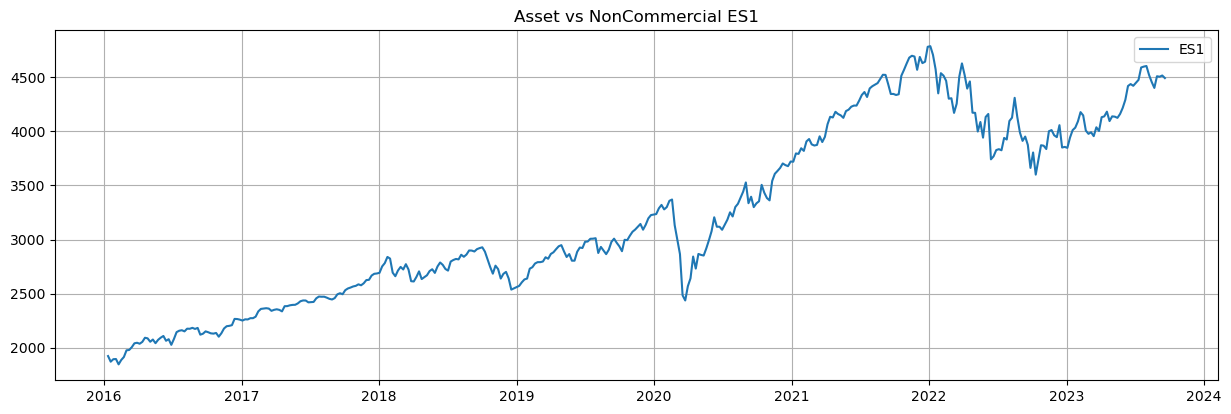

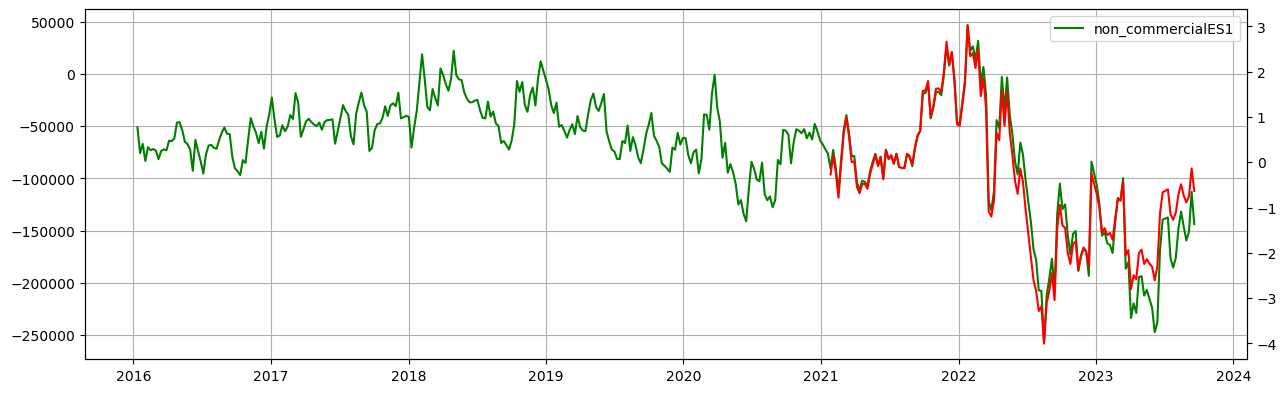

In [24]:
plot(d = stonks_HF['ES1'])

In [25]:
page_title_text = 'My report'
title_text = 'COT report'
text = 'welcome '
prices_text = 'historical prices'
stats_text = 'historical stats'

html = f'''
    <html>
        <head>
            <title>{page_title_text}</title>
        </head>
        <body>
            <h1>{title_text}</h1>
            <p>{text}</p>
            {fx['AUDUSD'].tail(10).append(fx['AUDUSD'].describe()).to_html()}
        </body>
    </html>
    '''
with open('html_report.html', 'w') as f:
    f.write(html)

C:\Users\CP85VC\AppData\Local\Temp\ipykernel_36260\3755988411.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  {fx['AUDUSD'].tail(10).append(fx['AUDUSD'].describe()).to_html()}


4704

##jinja 2 put special placeholds in template to allwo code simialr to python sytnax
#requires a report_template.html file (can create one with text editor)

In [26]:
from jinja2 import Environment, FileSystemLoader


In [27]:
env = Environment(loader = FileSystemLoader('templates_html'))
template = env.get_template('report_template.html')

html = template.render(page_title_text = "My report",
                       title_text = 'COT Report',
                       text = 'yada',
                       AUDUSD = fx['AUDUSD'].tail(10).append(fx['AUDUSD'].describe()).to_html())

with open('html_report_jinja.html', 'w') as f:
    f.write(html)

TemplateNotFound: report_template.html

In [ ]:
HISTORICAL_FILE_COT_AUDUSD_HOME = r'C:\Users\home\OneDrive\MacroData\'2005.03-2023.07_AUDUSD.pkl'

class AssetClass:
    NFP = 'NFP'
    CPI = 'CPI'
    GDPN = 'GDPN' 
    COT_AUDUSD = 'COT_AUDUSD'

class Directory:
    OFFICE = 'office'
    HOME = 'home'

def open_historical(asset_class, directory):
    '''
    Retrieves historical data from 'database', i.e., can use offline.
    asset_class: Asset class (NFP, CPI, GDPN)
    directory: Directory path (office, home)
    '''
    if asset_class == AssetClass.NFP:
        if directory == Directory.OFFICE:
            output_historical = pd.read_pickle(HISTORICAL_FILE_NFP_OFFICE)
        elif directory == Directory.HOME:
            output_historical = pd.read_pickle(HISTORICAL_FILE_NFP_HOME)
    elif asset_class == AssetClass.CPI:
        if directory == Directory.OFFICE:
            output_historical = pd.read_pickle(HISTORICAL_FILE_CPI_OFFICE)
        elif directory == Directory.HOME:
            output_historical = pd.read_pickle(HISTORICAL_FILE_CPI_HOME)
    elif asset_class == AssetClass.GDPN:
        if directory == Directory.HOME:
            output_historical = pd.read_pickle(HISTORICAL_FILE_GDPN_HOME)
    elif asset_class == AssetClass.COT_AUDUSD:
        if directory == Directory.HOME:
            output_historical = pd.read_pickle(HISTORICAL_FILE_COT_AUDUSD_HOME)

    return output_historical

print(open_historical('COT_AUDUSD', 'home').columns)
open_historical('COT_AUDUSD', 'home').loc[:, 'z_score'].plot(grid = True)

In [ ]:
open_historical('COT_AUDUSD', 'home').loc[:, 'net_spec'].plot(grid = True)

In [ ]:
open_historical('COT_AUDUSD', 'home').loc[:, 'AUDUSD'].plot(grid = True)

In [ ]:
ECI_obj = DownloadData_v4.DownloadData(pair = ['ECI SA% Index','PCE DEFY Index', 'PCE CYOY Index'], \
                                                 fields = ['PX_LAST'], \
                                                 startDate = dt.datetime(1990,1,1), \
                                                 endDate = dt.datetime.today(), \
                                                 period = 'QUARTERLY', \
                                                source = 'blp')
eci = ECI_obj.get_data_blp_historical(0).fillna(method = 'ffill')


In [ ]:
eci.tail()

In [ ]:
eci['mean_annualized'] = eci['ECI SA% Index'].rolling(4).mean()*4
eci.tail(10)

In [ ]:
eci[['mean_annualized', 'PCE DEFY Index', 'PCE CYOY Index']].plot(grid = True, figsize = (14,10))

In [ ]:
eci_Y = eci[['ECI SA% Index', 'PCE DEFY Index', 'PCE CYOY Index']].resample('Y').mean()
eci_Y['ECI_yearly']= eci_Y['ECI SA% Index']*4
eci_Y.round(2)


In [ ]:
print('changes')
print('-'*50)
eci_Y.diff().round(2)

print('corr')
print('-'*50)
eci_Y.diff().corr()